In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from models.pipeline import Pipeline
from utils.view import draw_grid, draw_task
from utils.latent_space import reconstruct_grid

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v2_vampprior import ConvolutionalVAEV2_VampPrior
from models.convolutional_vae_v2_vampprior import preprocess_grid as preprocess_grid_vp, postprocess_grid as postprocess_grid_vp
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=512,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_512_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [18]:
model = ConvolutionalVAEV3(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=256,
    feature_dim=[4, 4]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev3_256_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev3,
    postprocess_fn=postprocess_vaev3,
)
model_type = "vae"

In [3]:
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=512,
    embedding_dim=256,
    commitment_cost=0.25
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vqvae_6x6x256_512_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [68]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/vq_vae_64_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [71]:
n_components = 256

# input_dim = n_components
input_dim = 128
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

checkpoint = torch.load('../../checkpoints/ppca128_vae_64_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [10]:
model = ConvolutionalVAEV2_VampPrior(
        in_channels=10, 
        starting_filters=64, 
        latent_dim=128,
        feature_dim=[8, 8],
        num_pseudo_inputs=64
    ).to(device)
    
checkpoint = torch.load('../../checkpoints/conv_vaev2_vampprior_b1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid_vp,
    postprocess_fn=postprocess_grid_vp,
)
model_type = "vae"

In [3]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [10]:
def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

def reconstruct_grids(pipeline: Pipeline, task, mode, model_type="vq"):
    with torch.no_grad():
        pairs = task[mode]

        inputs = []
        inputs_recon = []
        
        outputs = []
        outputs_recon = []
        
        for input, output in pairs:
            inputs.append(input)
            input_decoded = reconstruct_grid(pipeline, input, model_type)
            inputs_recon.append(input_decoded)
            
            outputs.append(output)
            output_decoded = reconstruct_grid(pipeline, output, model_type)
            outputs_recon.append(output_decoded)
        
        return inputs, inputs_recon, outputs, outputs_recon


In [11]:
train_recon_accuracy_per_task = {}
train_perf_per_task = {}

original_grids = []
decoded = []

# counter = 0
for puzzle_id, task in data.items():
    # if counter >= 10:
    #     break
    # counter += 1
    i, i_recon, o, o_recon = reconstruct_grids(pipeline, task, "test", model_type)
    accuracies = []
    perfects = []
    
    # original_grids.extend(i)
    original_grids.extend(o)
    # decoded.extend(i_recon)
    decoded.extend(o_recon)

    for idx, (original, reconstructed) in enumerate(zip(i, i_recon)):
        acc, perf = compute_accuracy(original, reconstructed)
        accuracies.append(acc)
        perfects.append(perf)

    for idx, (original, reconstructed) in enumerate(zip(o, o_recon)):
        acc, perf = compute_accuracy(original, reconstructed)
        accuracies.append(acc)
        perfects.append(perf)
    
    train_recon_accuracy_per_task[puzzle_id] = np.mean(accuracies)
    train_perf_per_task[puzzle_id] = np.mean(perfects)
    show_recon = False
    if show_recon:
        batch_size = len(i)
        fig, axs = plt.subplots(4, batch_size, figsize=(batch_size * 2, 8))

        titles = ["Input", "Input Recon", "Output", "Output Recon"]
        all_grids = [i, i_recon, o, o_recon]

        for row, (title, grids) in enumerate(zip(titles, all_grids)):
            for col in range(batch_size):
                img = grids[col]
            
                ax = axs[row, col] if batch_size > 1 else axs[row]
                draw_grid(ax, img, title if col == 0 else "")

        plt.tight_layout()
        plt.show()

        
    # print(puzzle_id, np.mean(accuracies), np.mean(perfects))

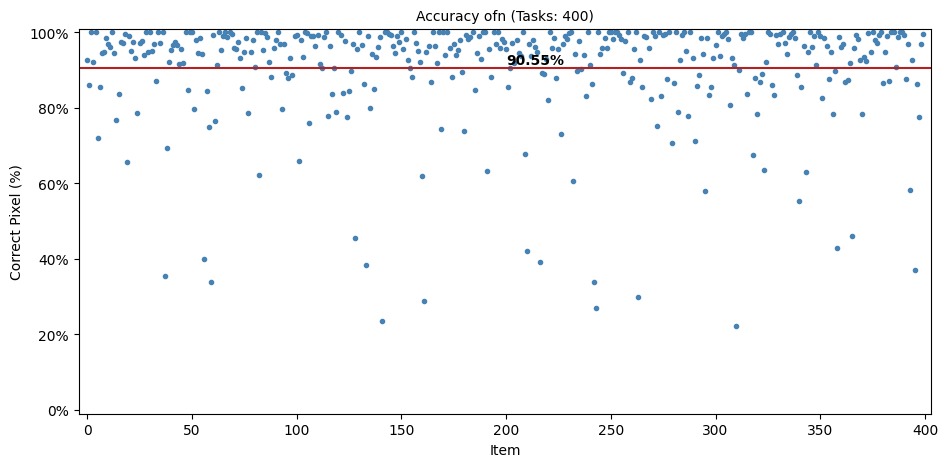

Number of 100% Correct: 65
Number of 90%+ Correct: 284
Number of 80%+ Correct: 345
Number of 70%+ Correct: 370


In [12]:
accuracies = list(train_recon_accuracy_per_task.values())
mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy ofn (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()
print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')

dict_keys([np.int64(4), np.int64(2), np.int64(1), np.int64(0), np.int64(6), np.int64(9), np.int64(7), np.int64(8), np.int64(3), np.int64(5)])


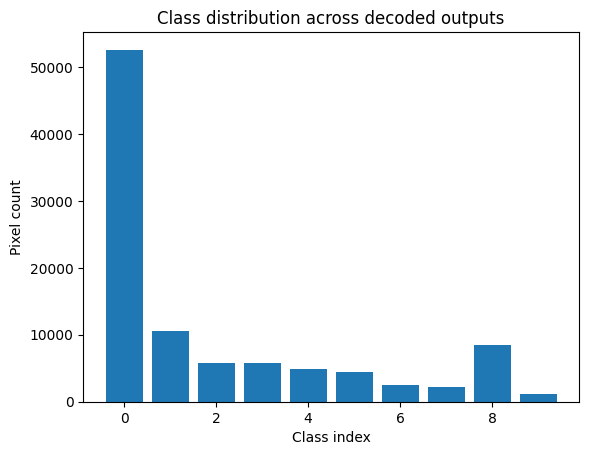

In [7]:
from collections import Counter

all_preds = []
for d in decoded:
    a = np.array(d).flatten()

    all_preds.extend(a)

counts = Counter(all_preds)
print(counts.keys())

plt.bar(counts.keys(), counts.values())
plt.xlabel("Class index")
plt.ylabel("Pixel count")
plt.title("Class distribution across decoded outputs")
plt.show()


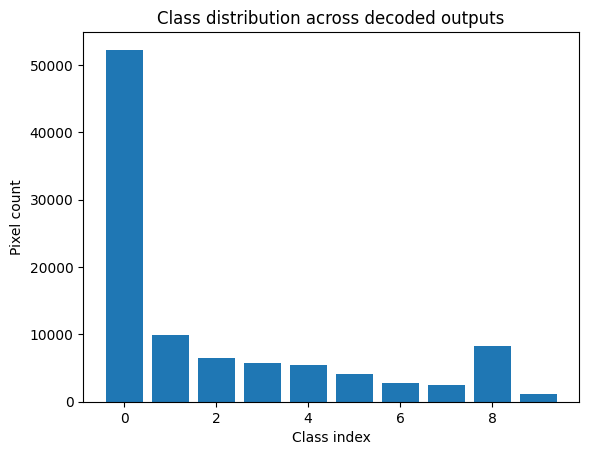

In [14]:
all_orig = []
for o in original_grids:
    a = np.array(o).flatten()

    all_orig.extend(a)

counts = Counter(all_orig)

plt.bar(counts.keys(), counts.values())
plt.xlabel("Class index")
plt.ylabel("Pixel count")
plt.title("Class distribution across decoded outputs")
plt.show()

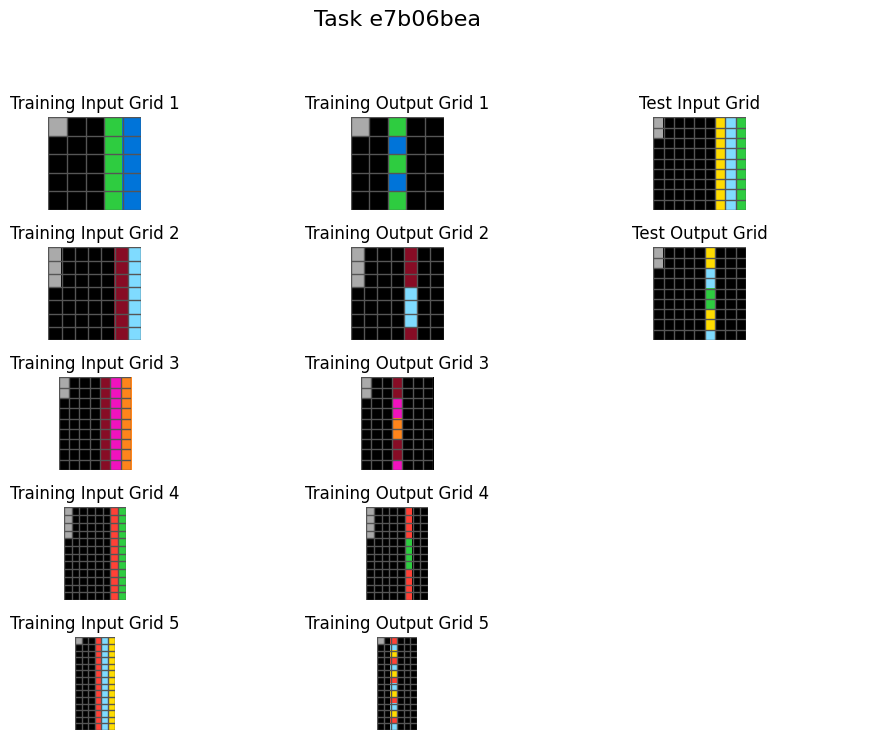

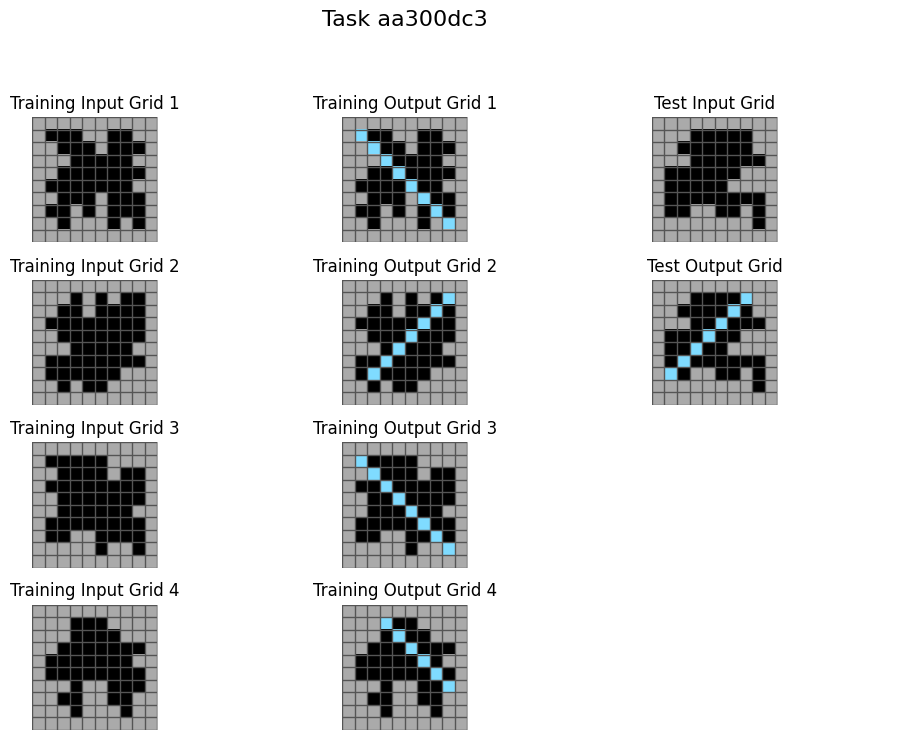

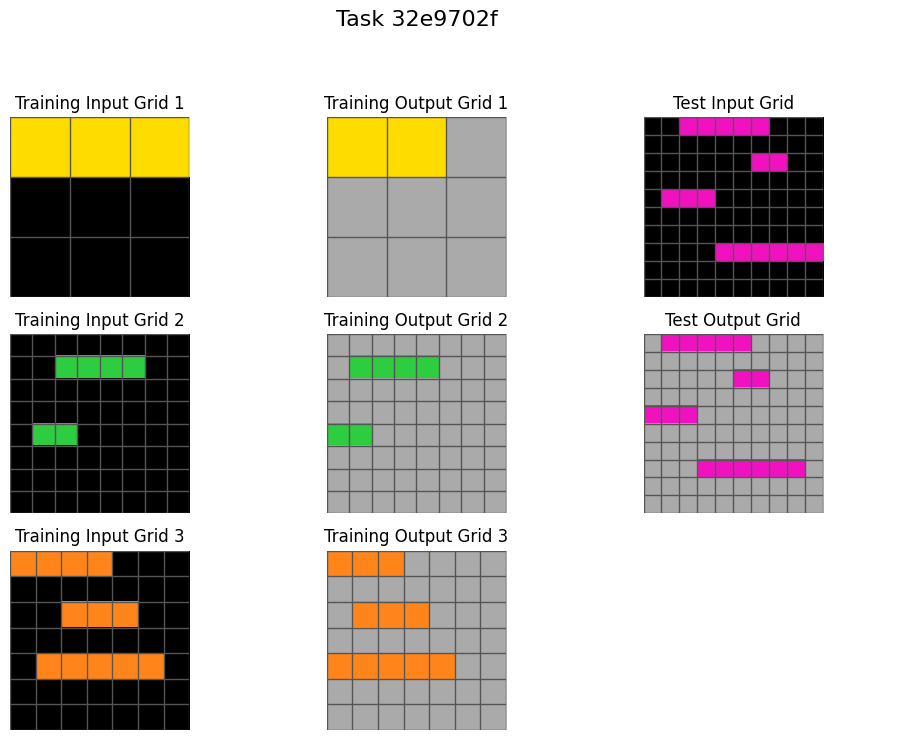

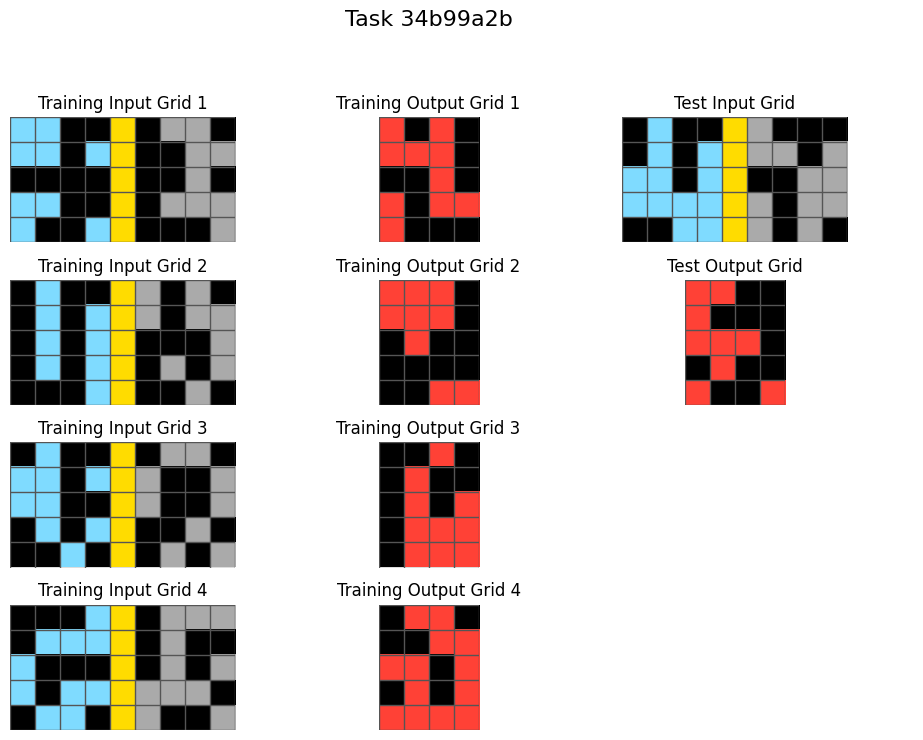

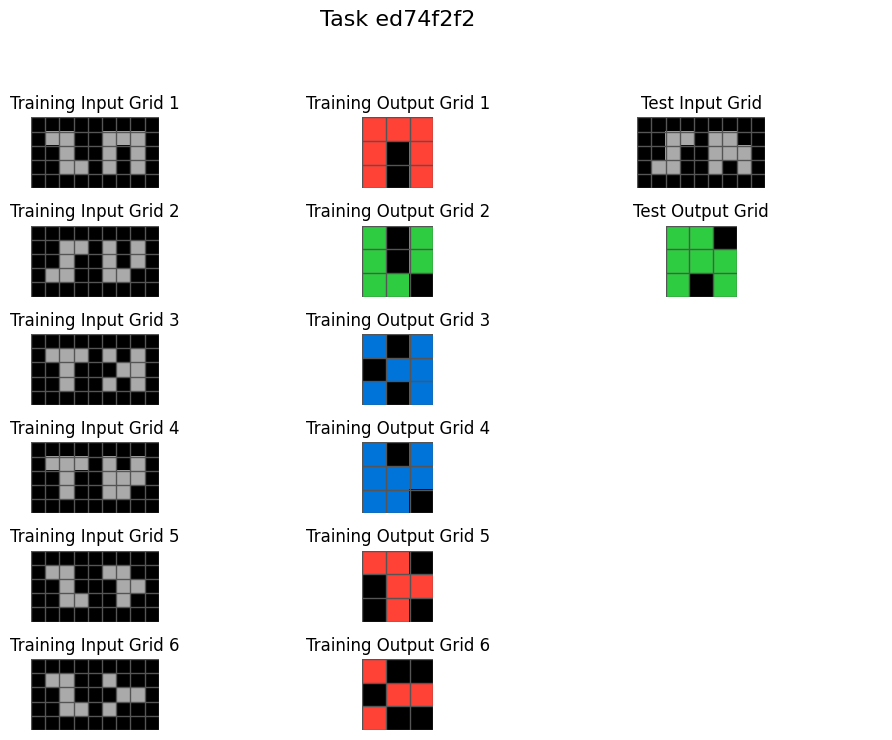

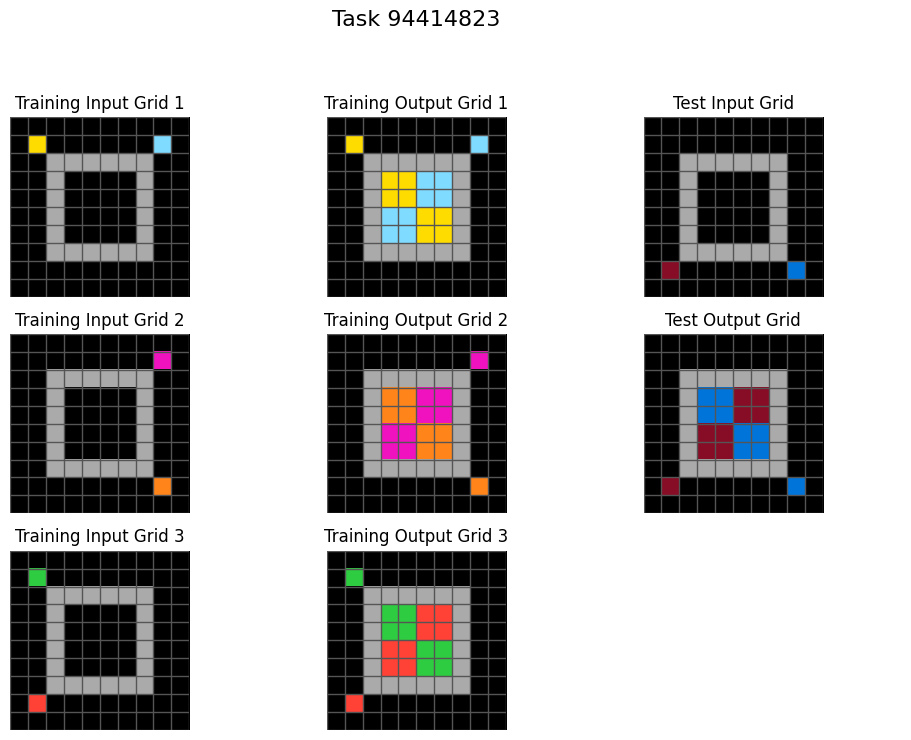

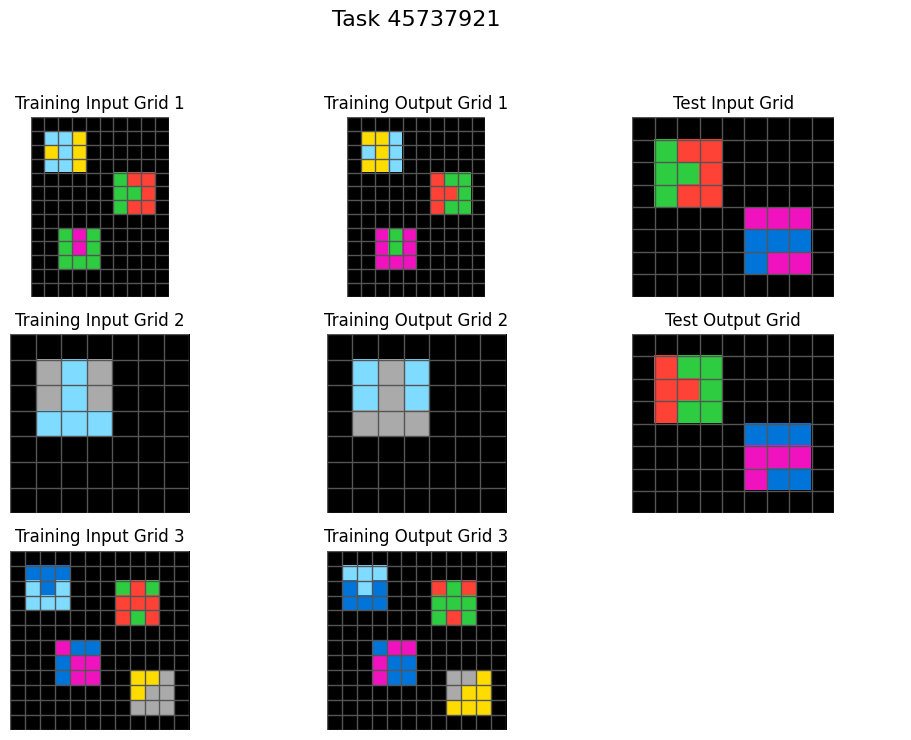

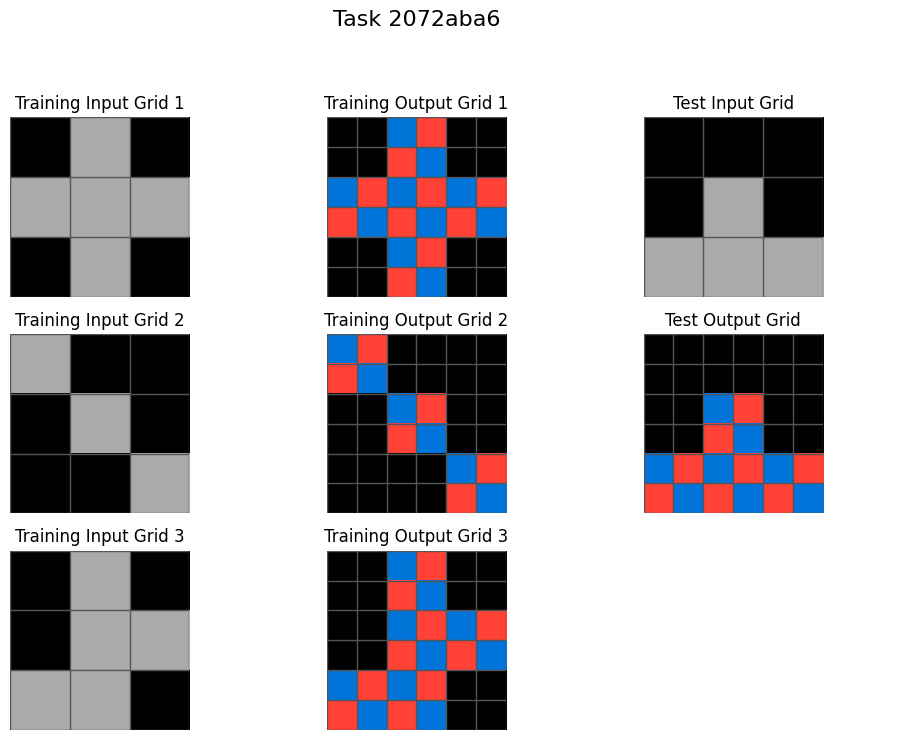

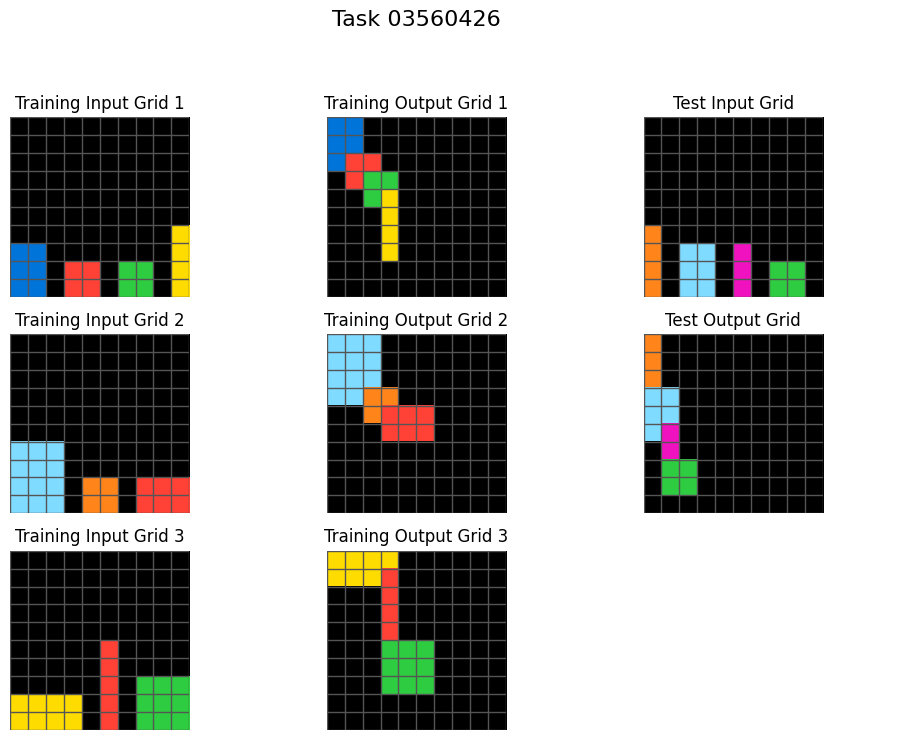

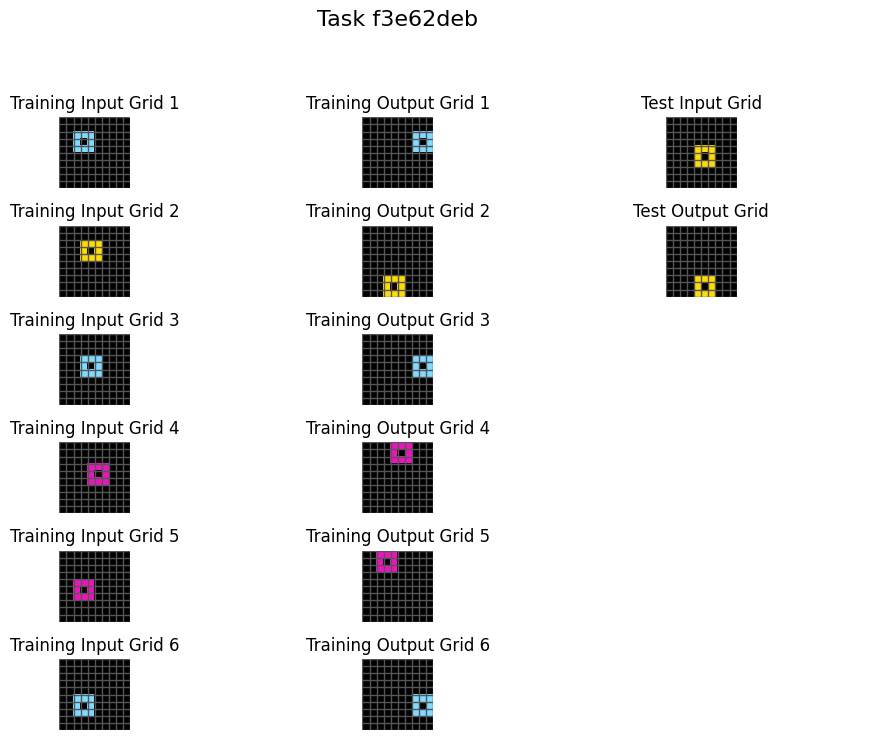

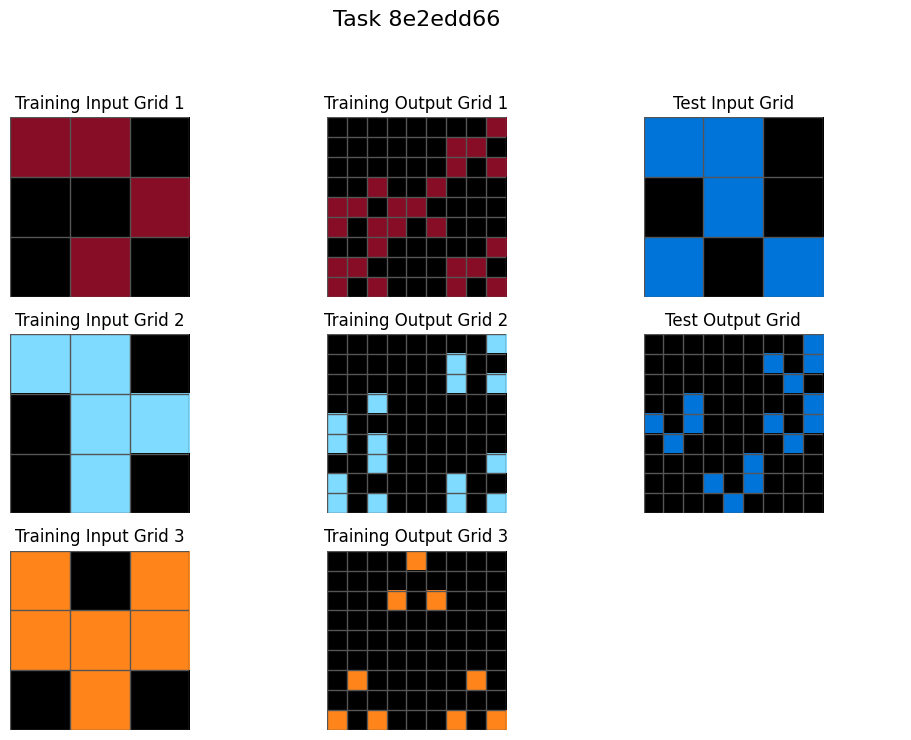

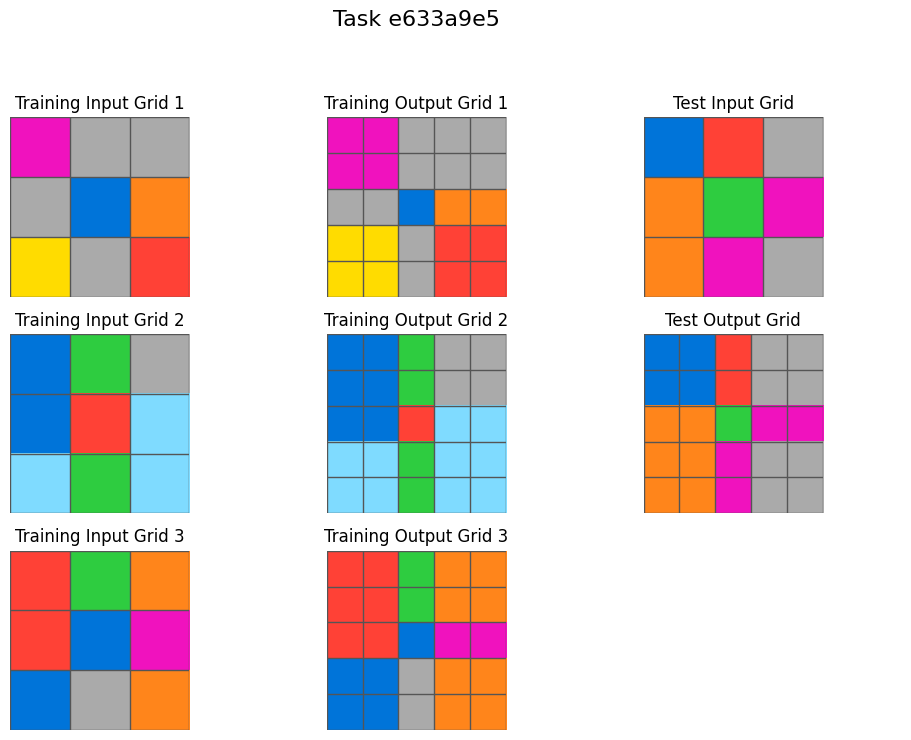

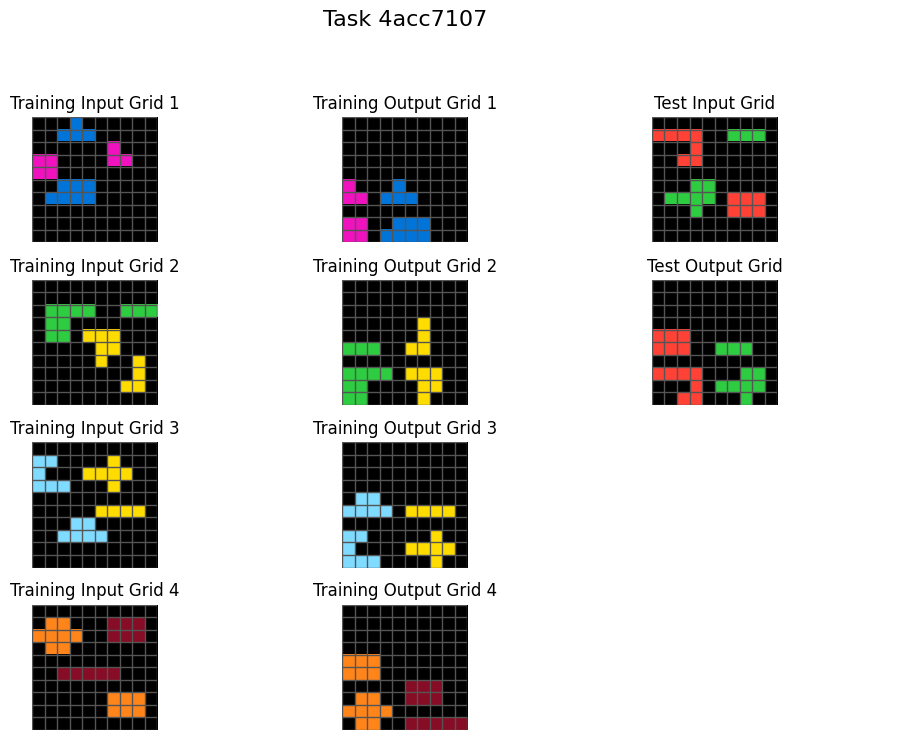

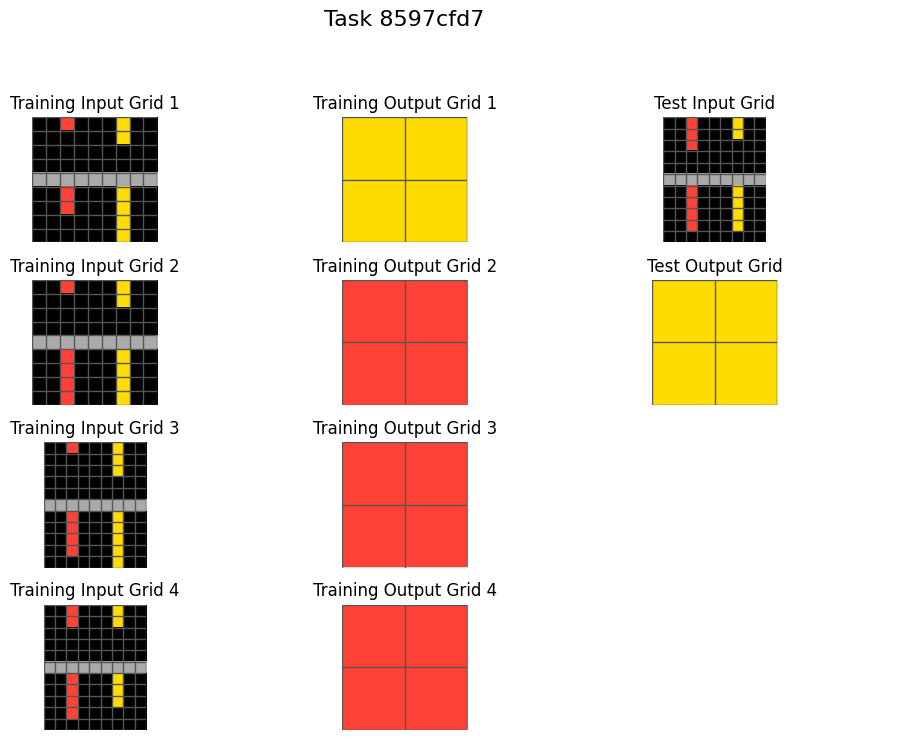

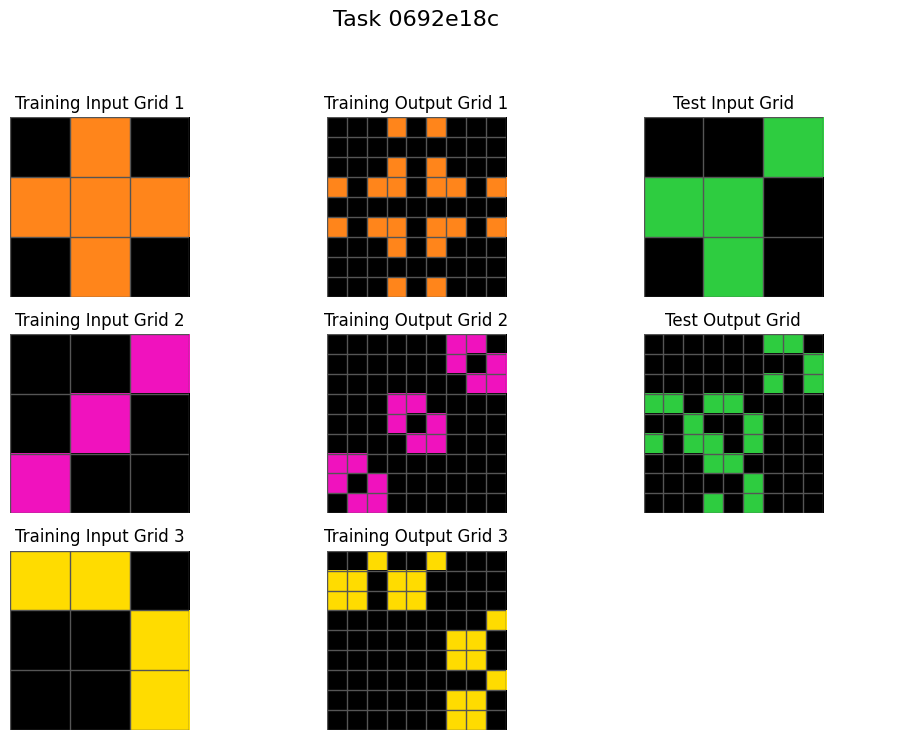

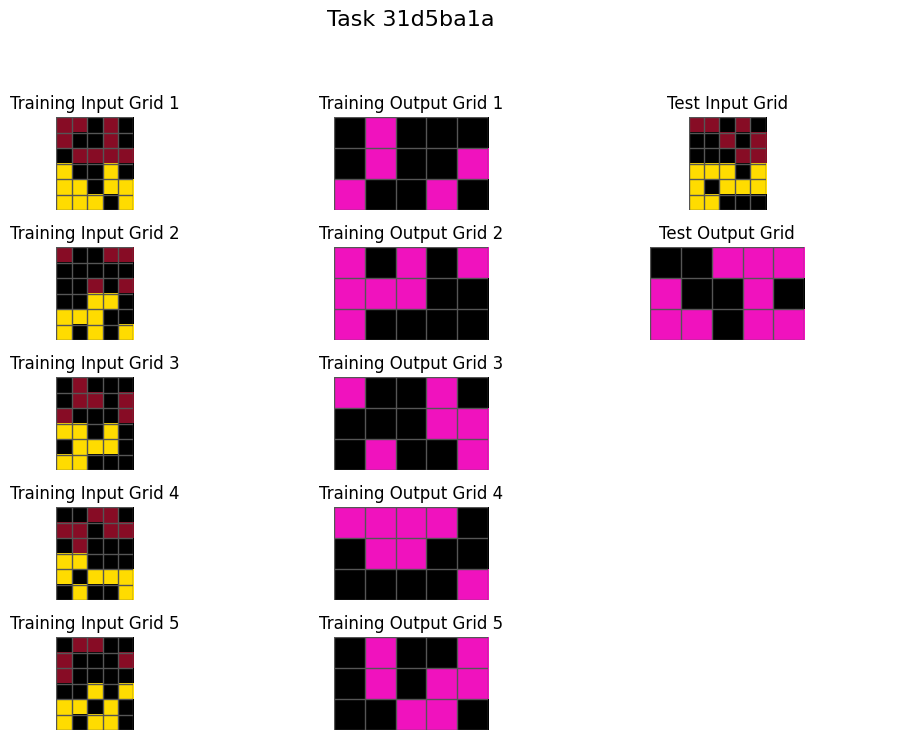

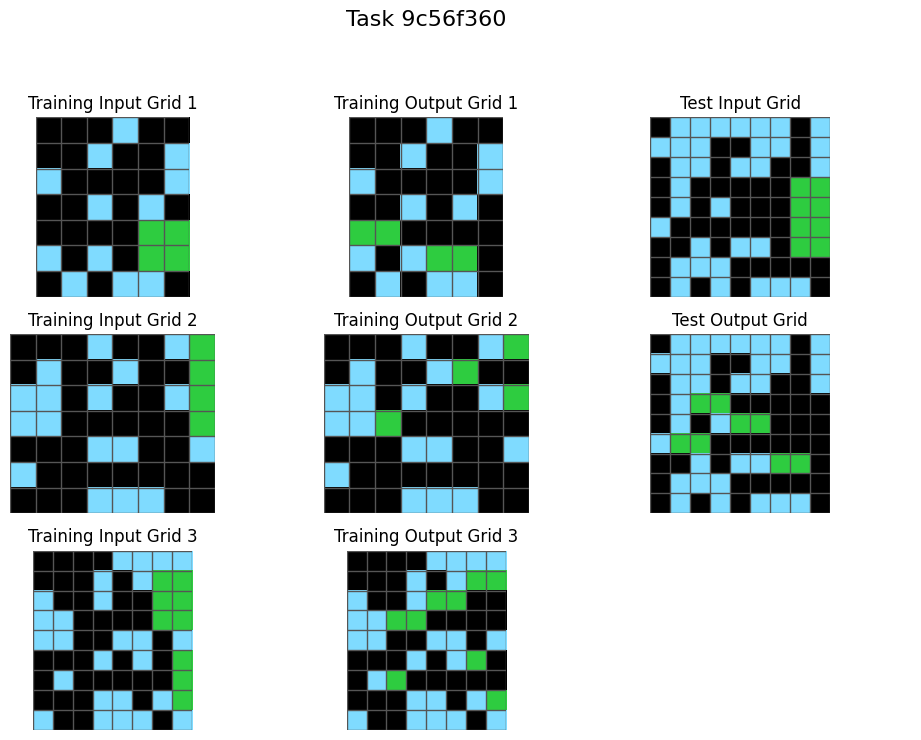

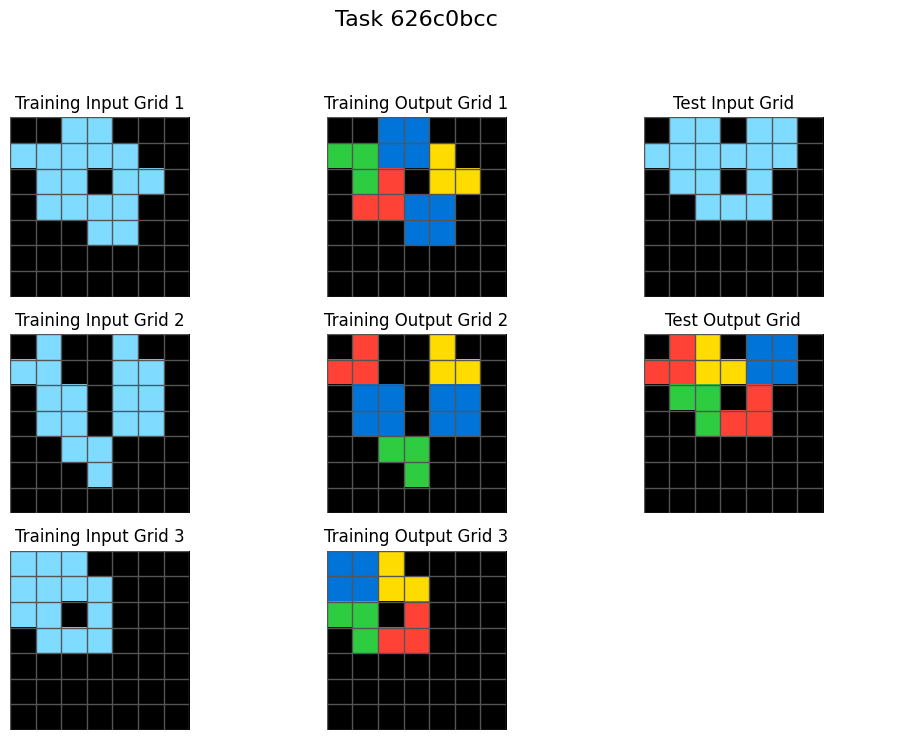

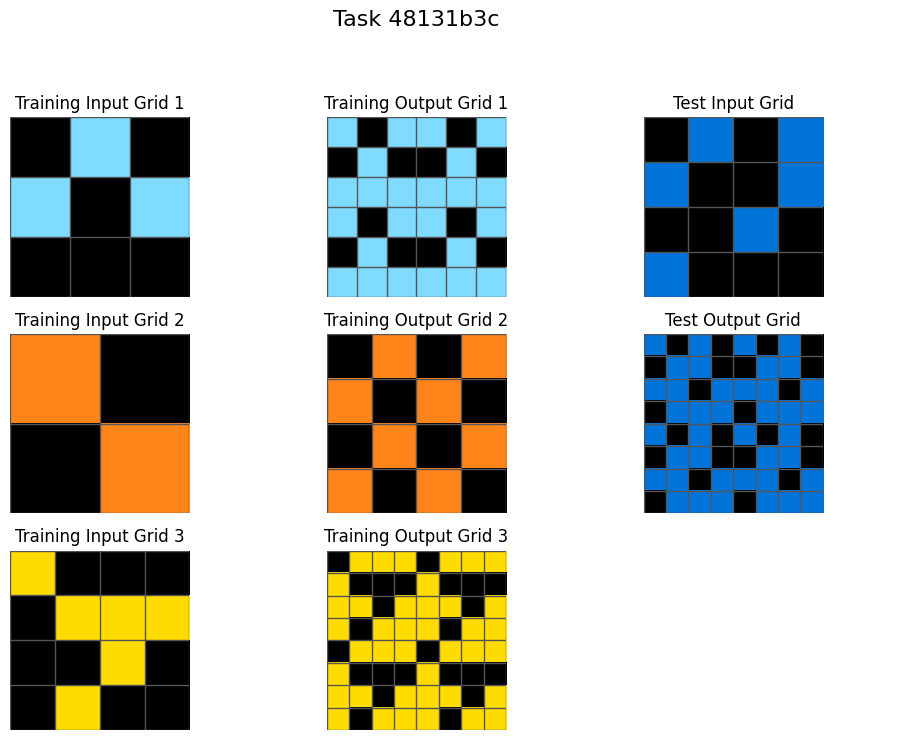

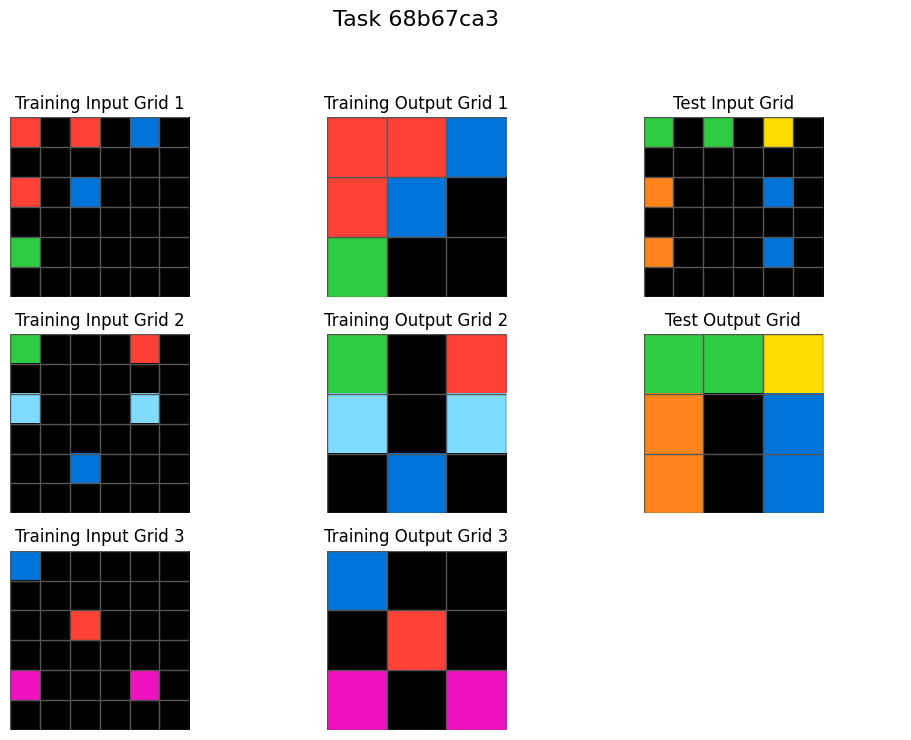

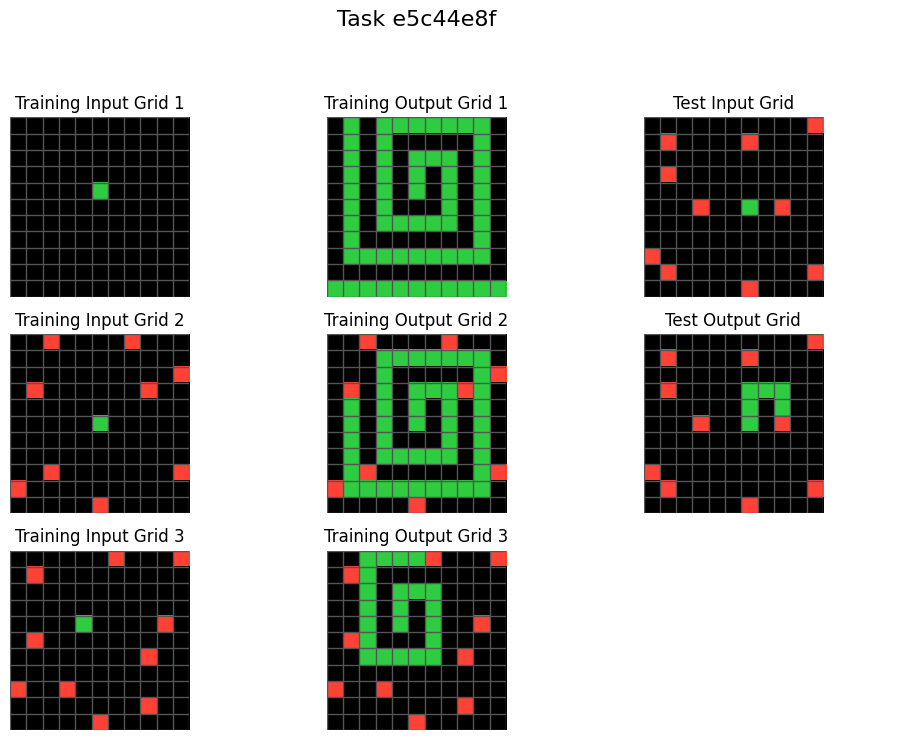

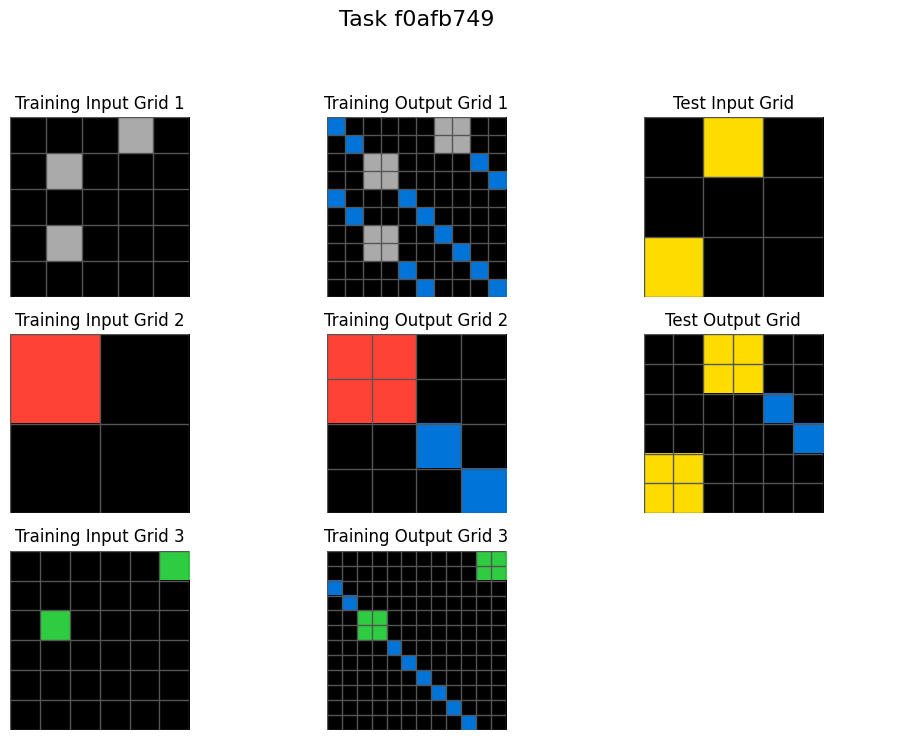

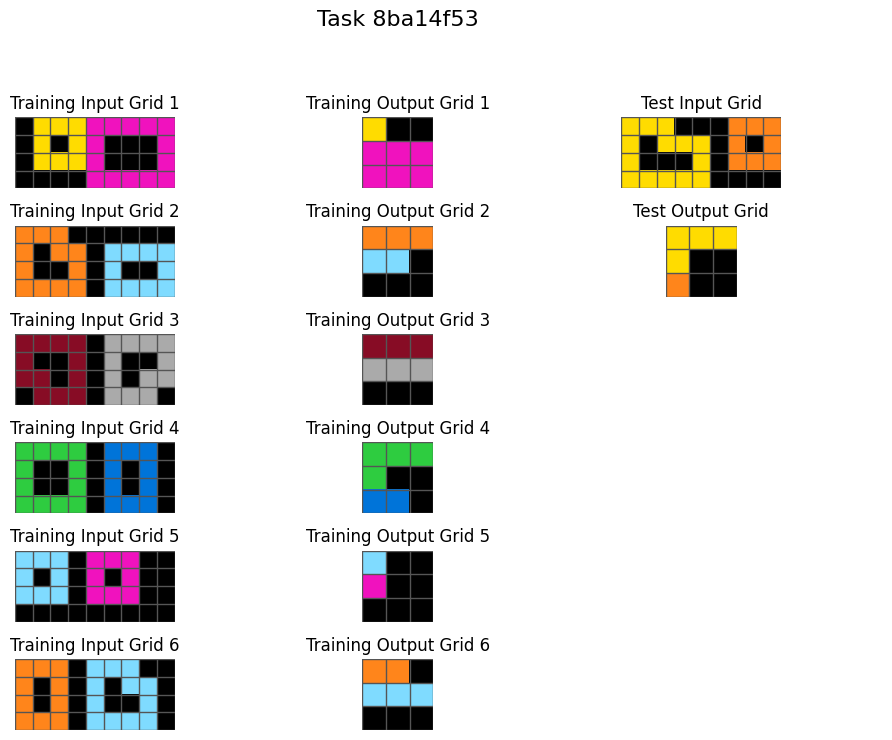

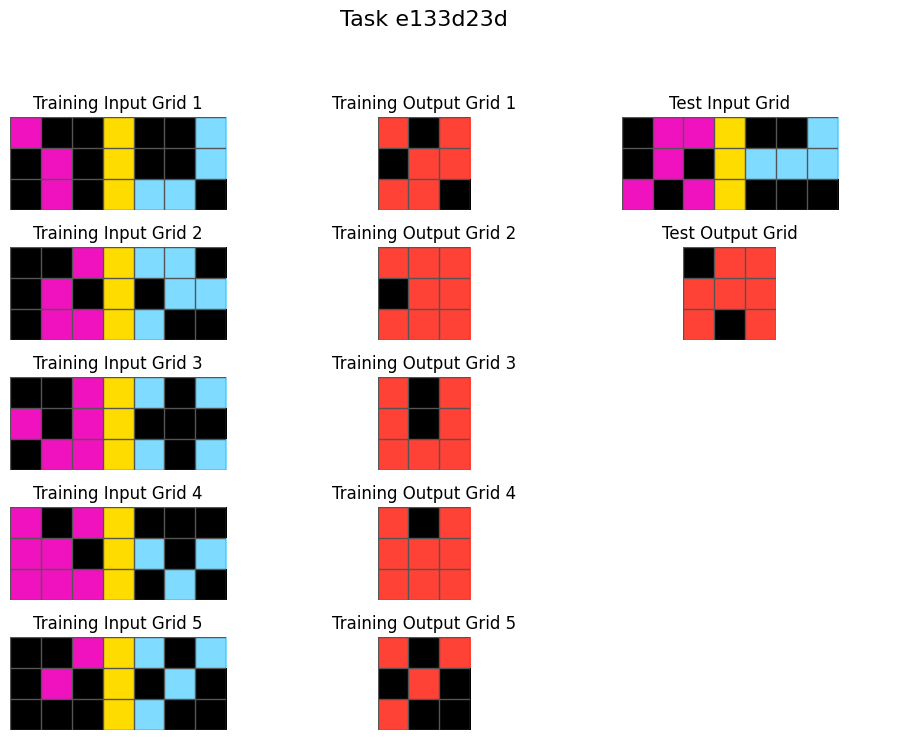

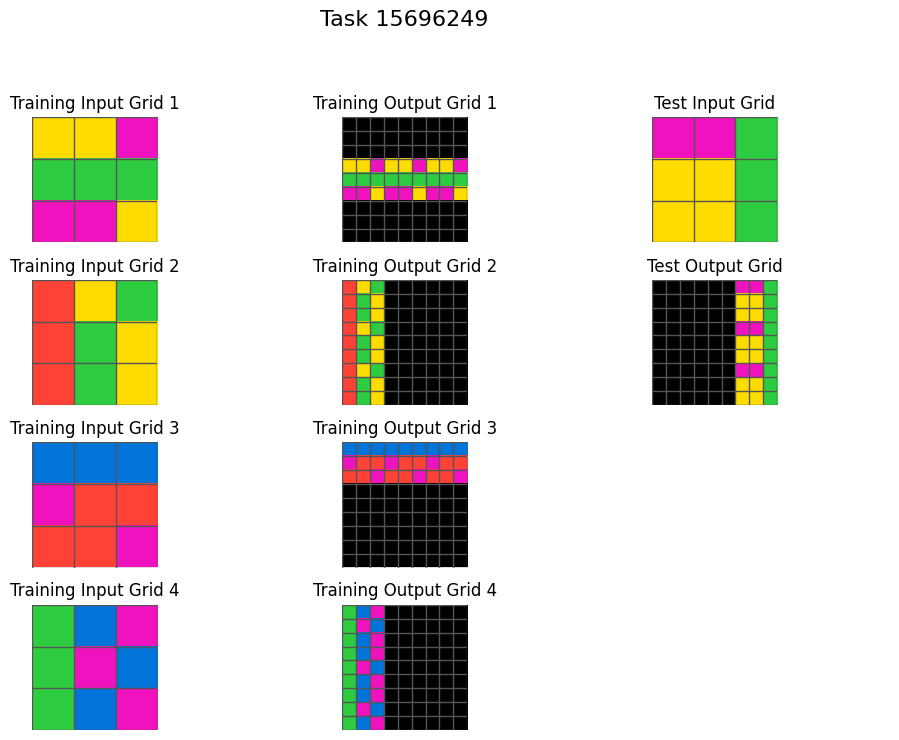

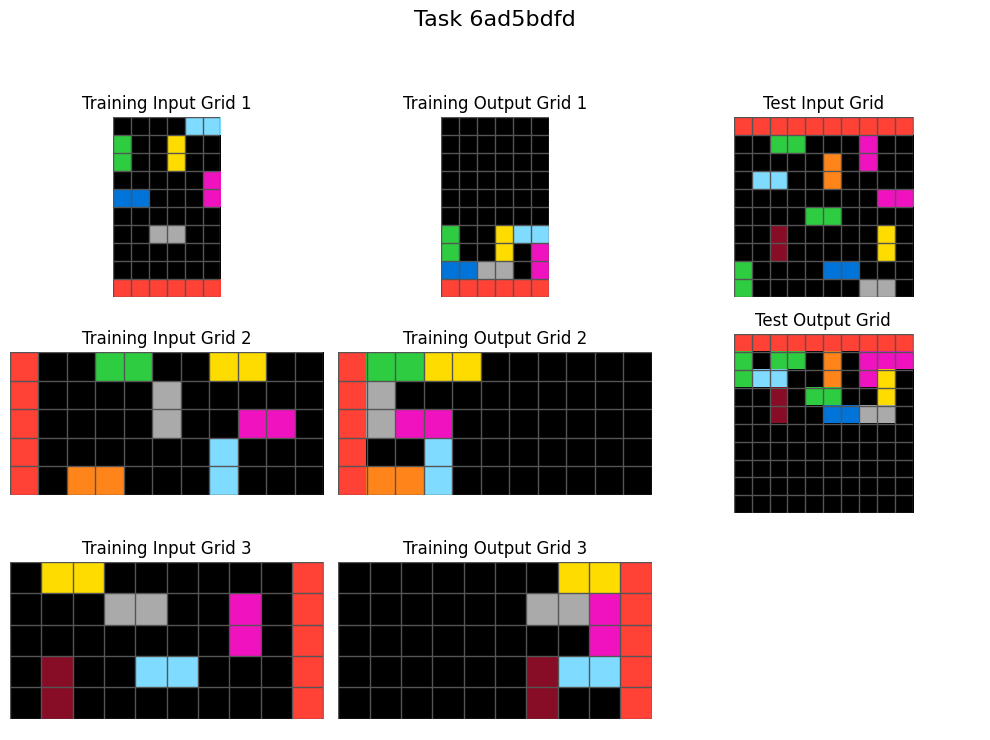

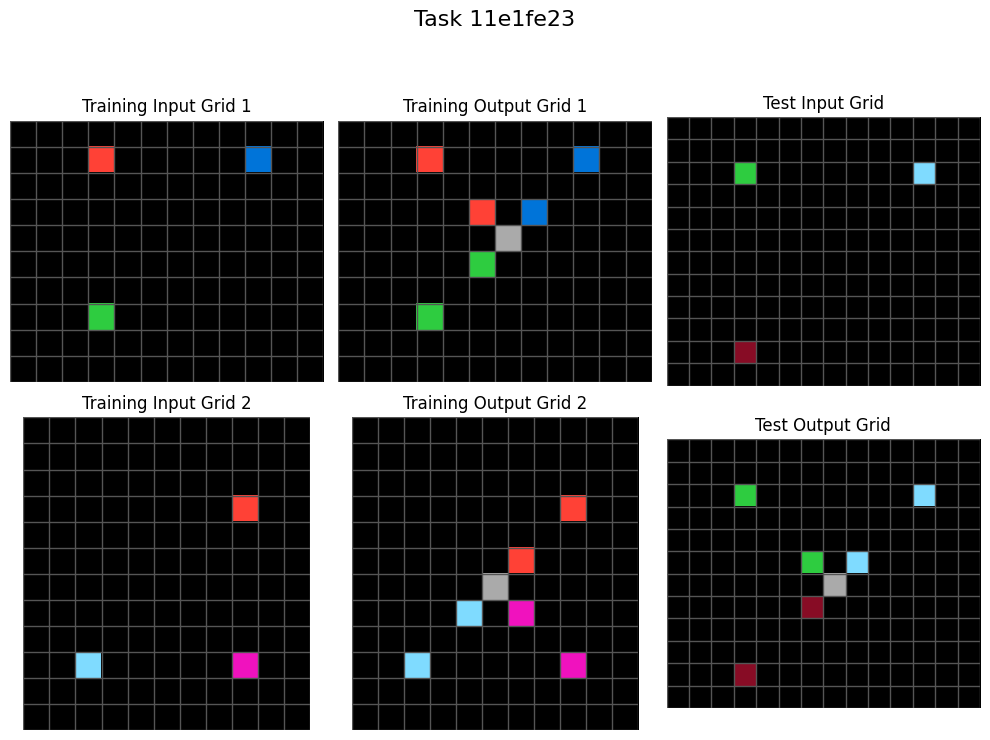

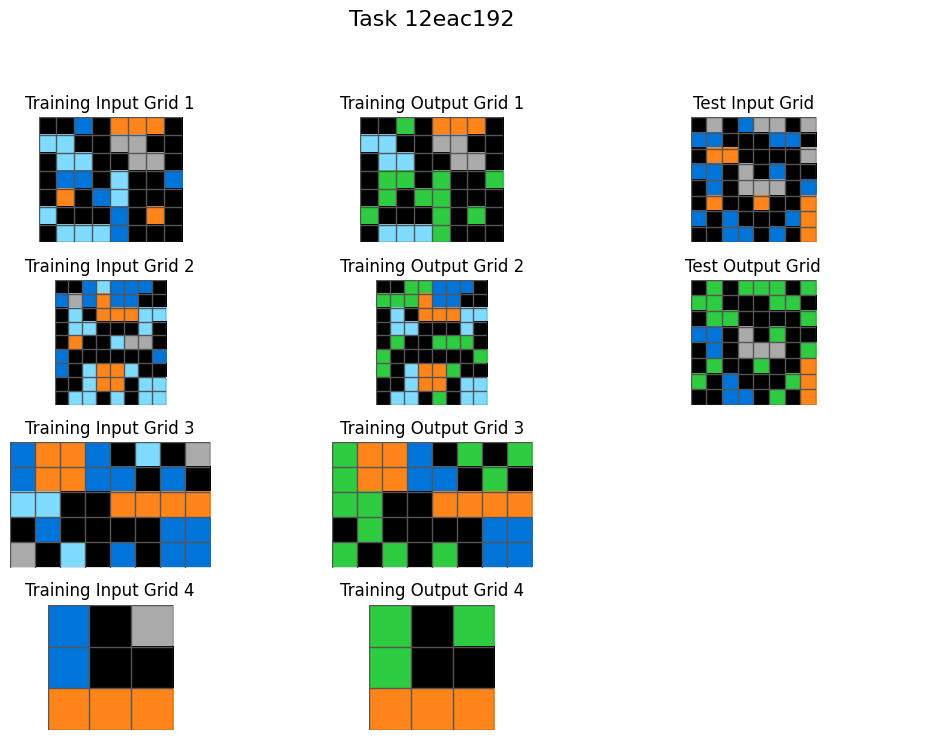

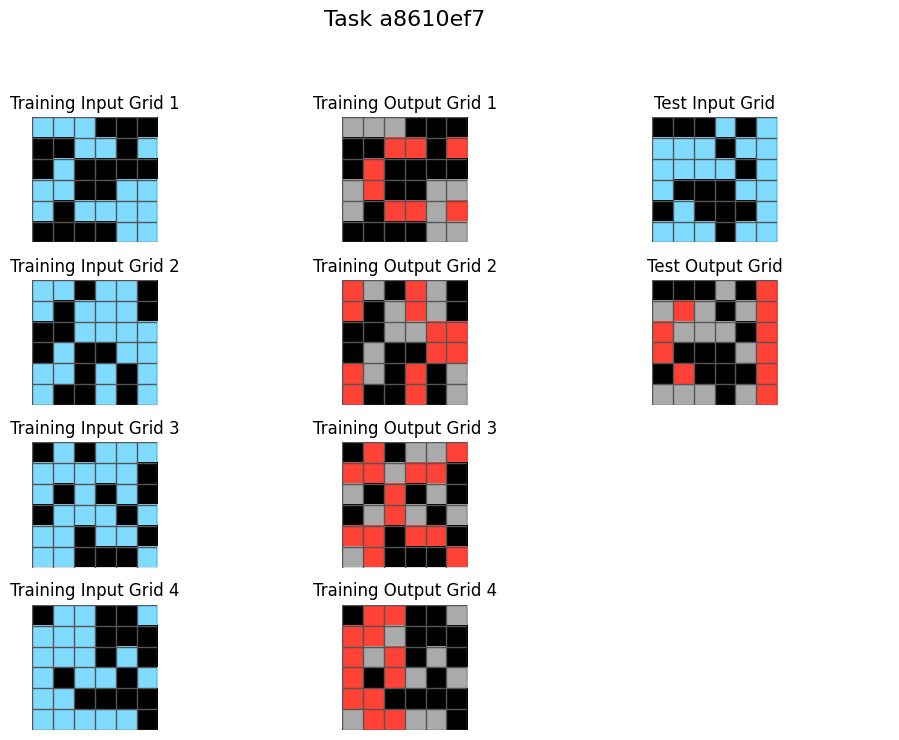

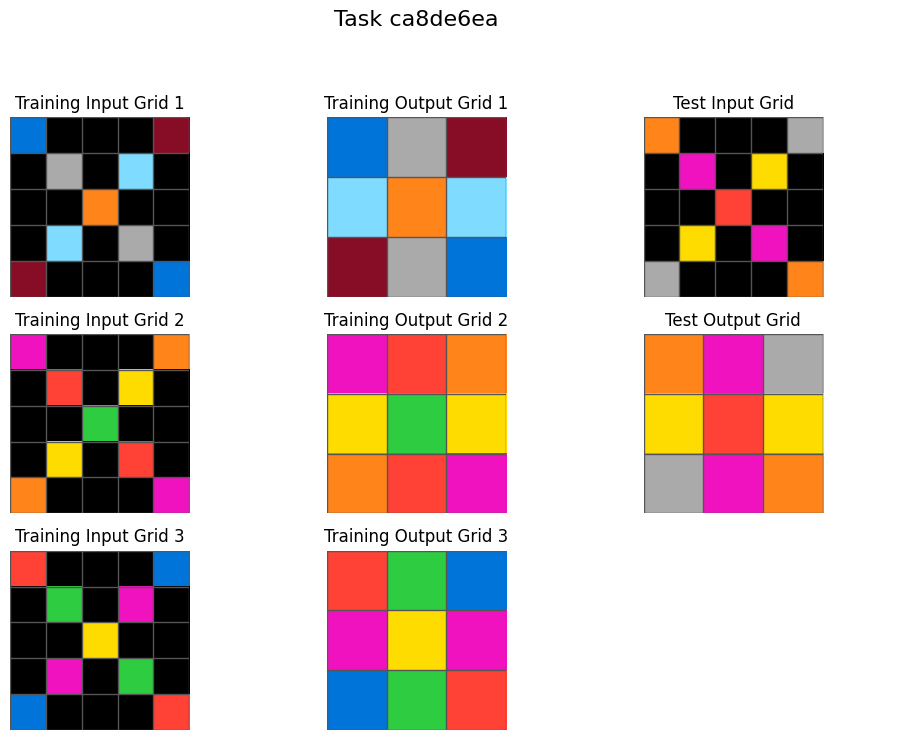

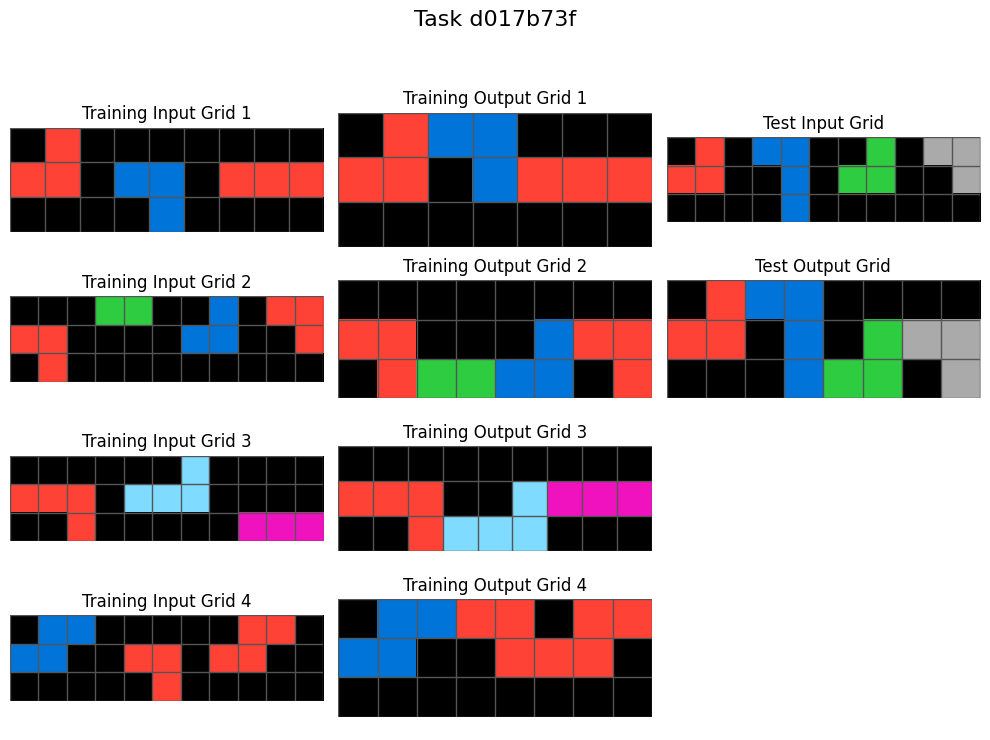

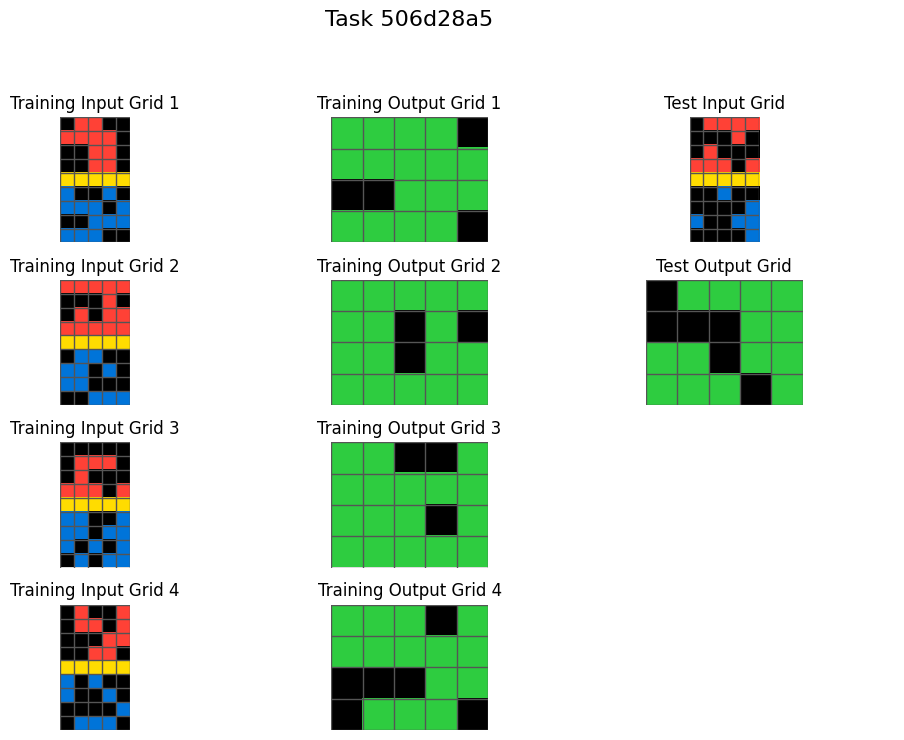

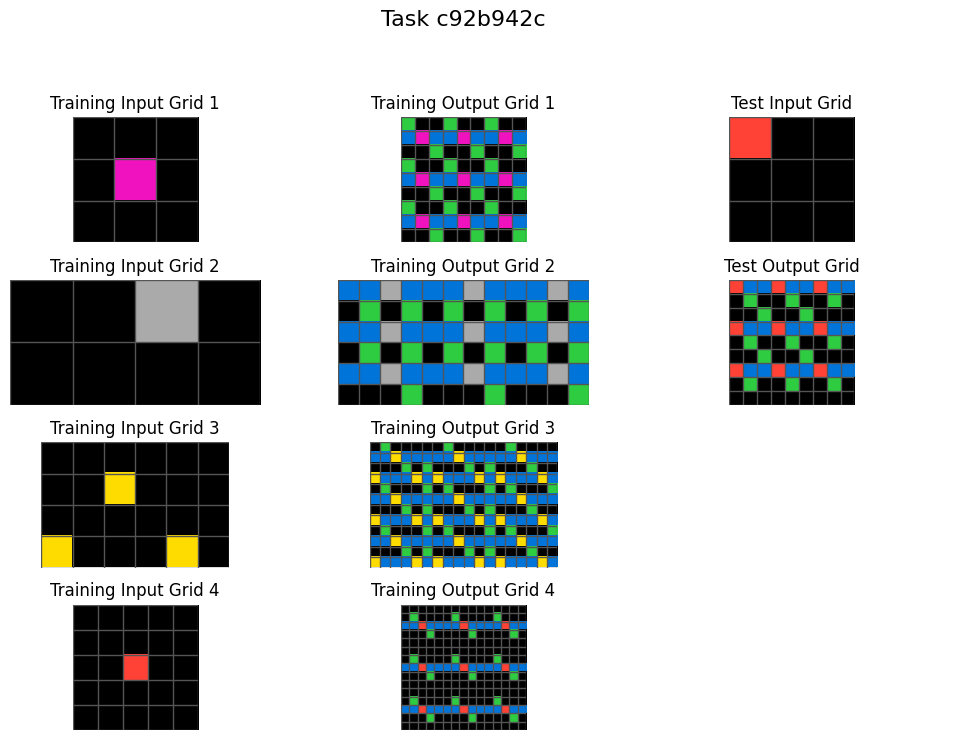

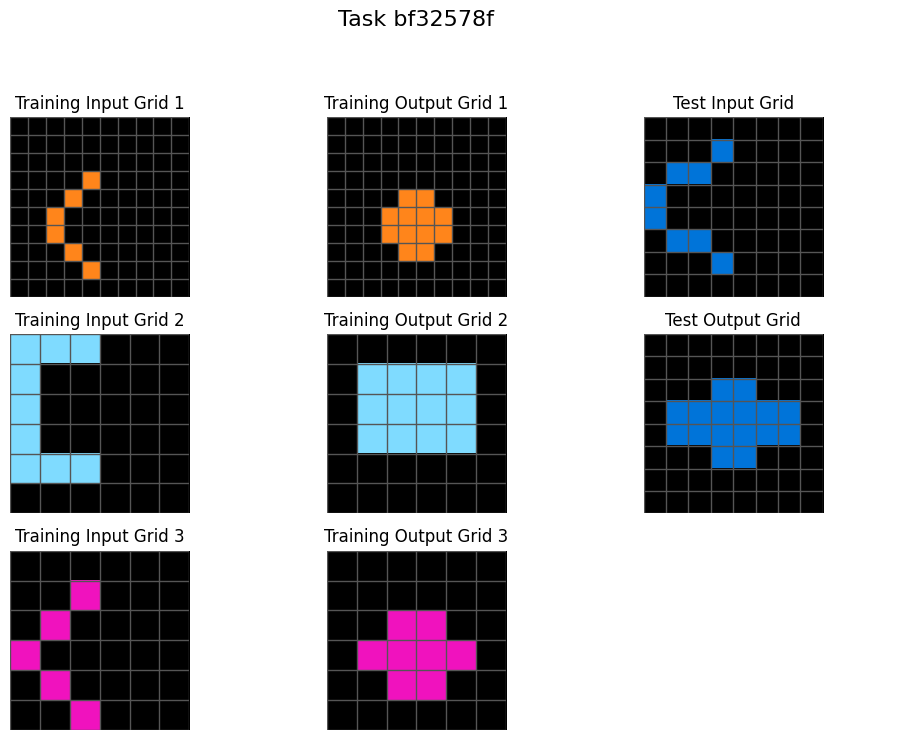

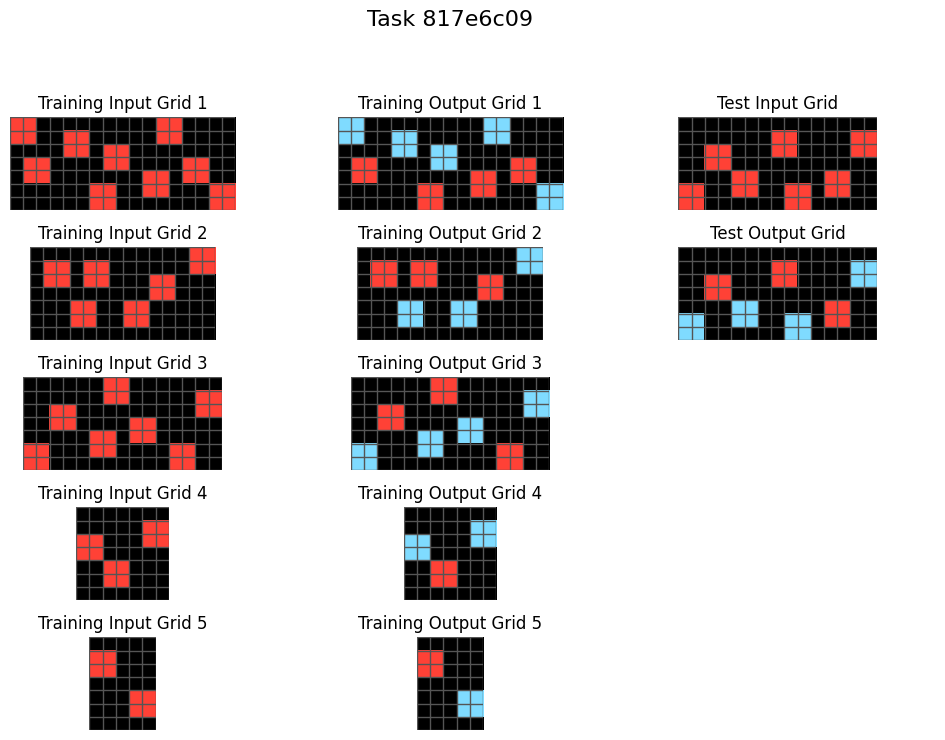

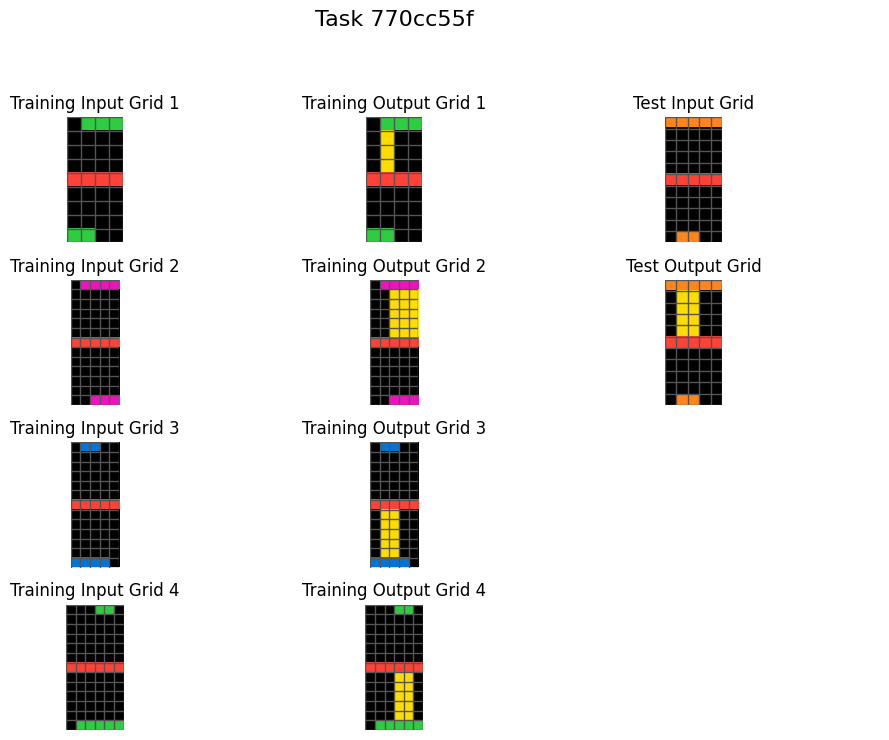

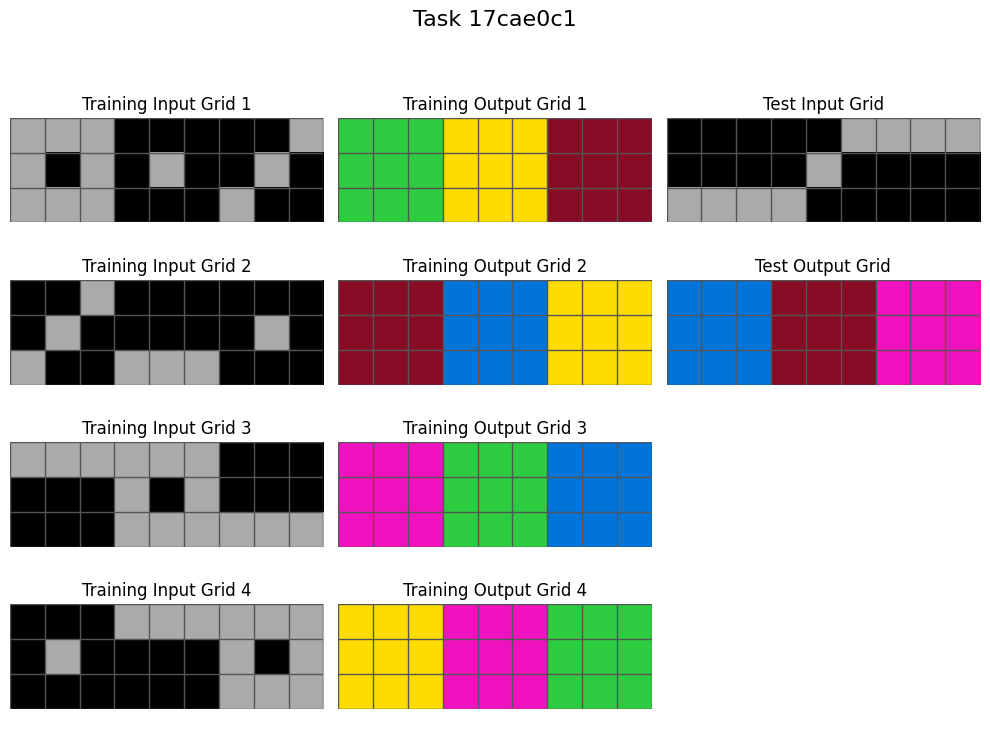

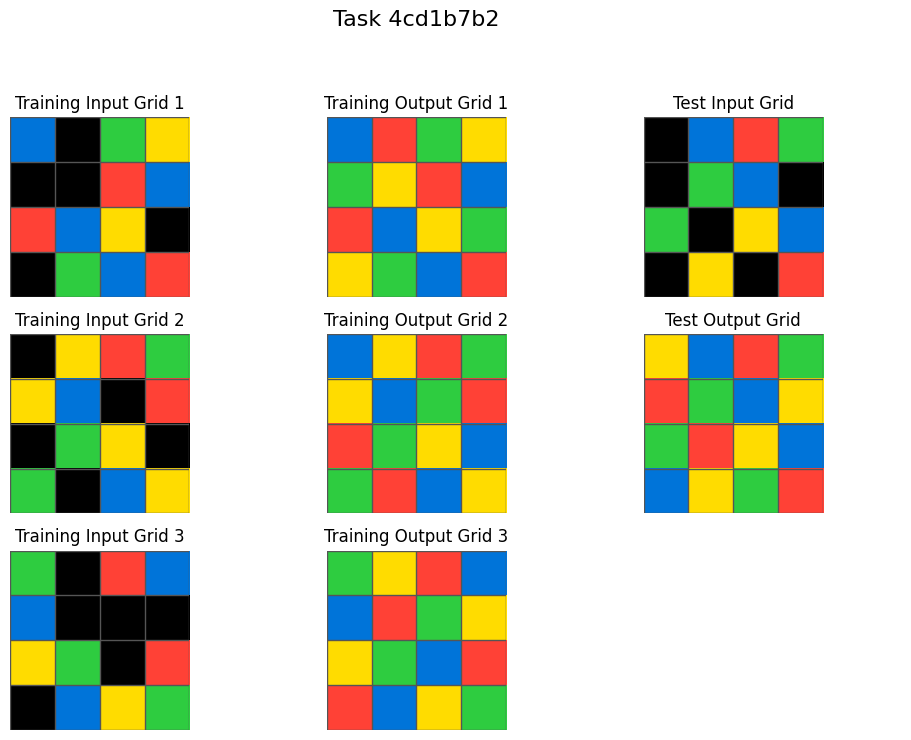

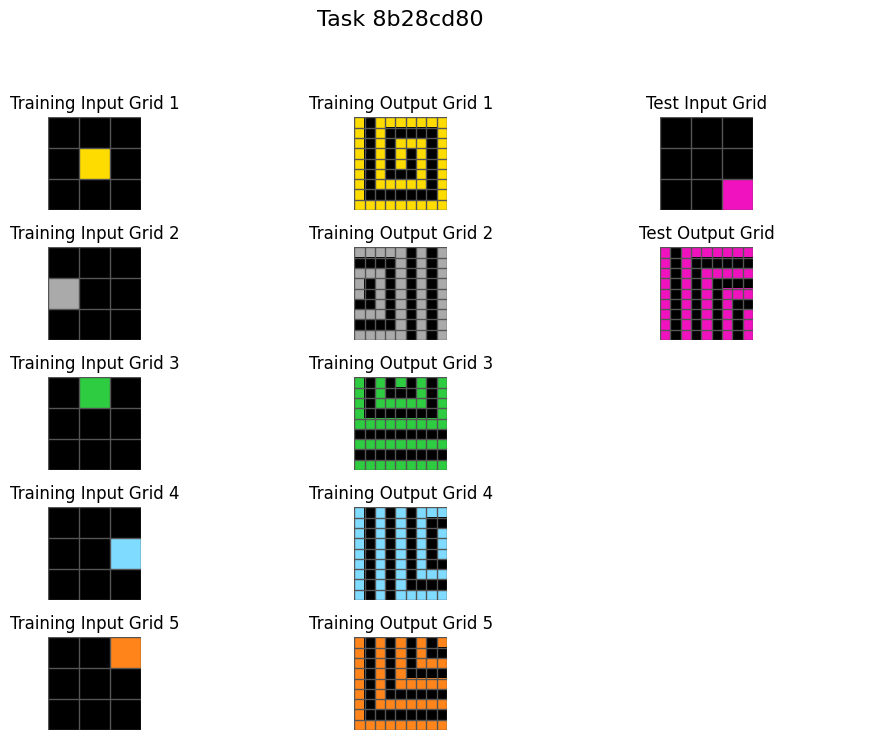

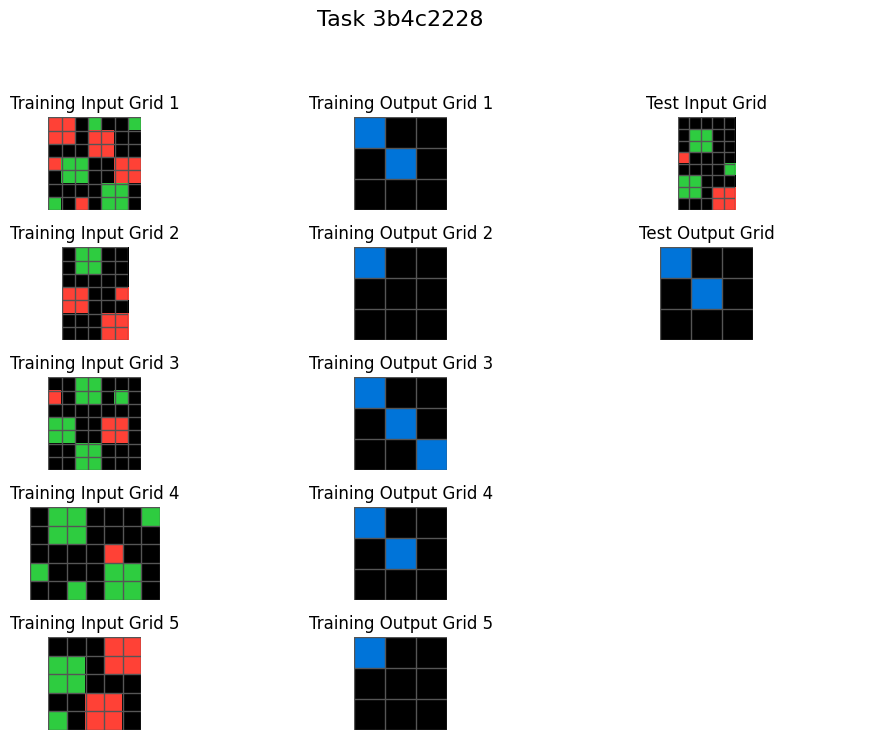

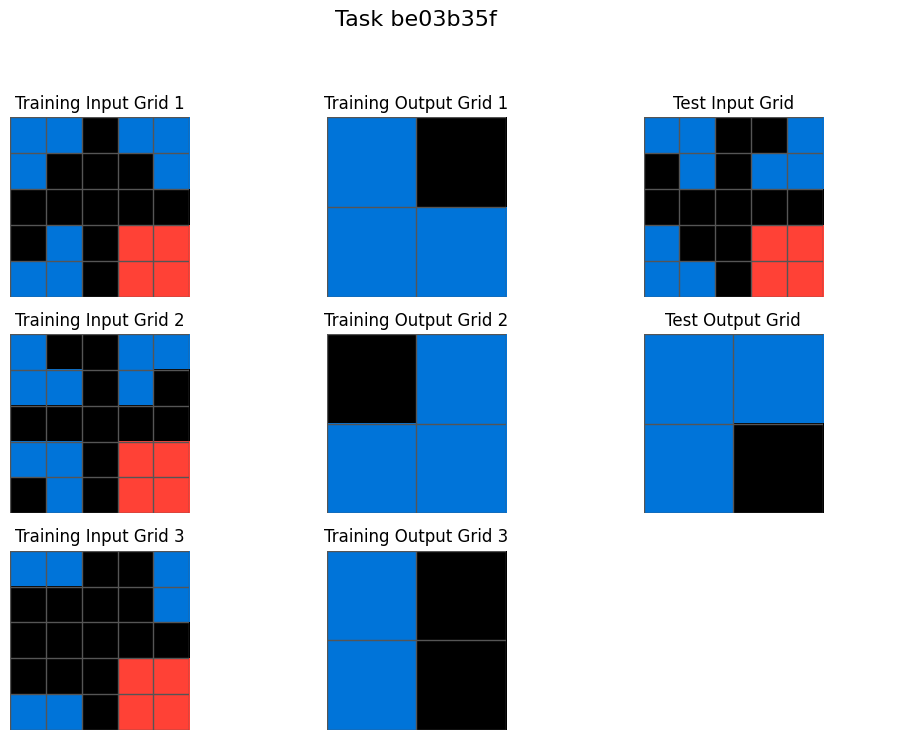

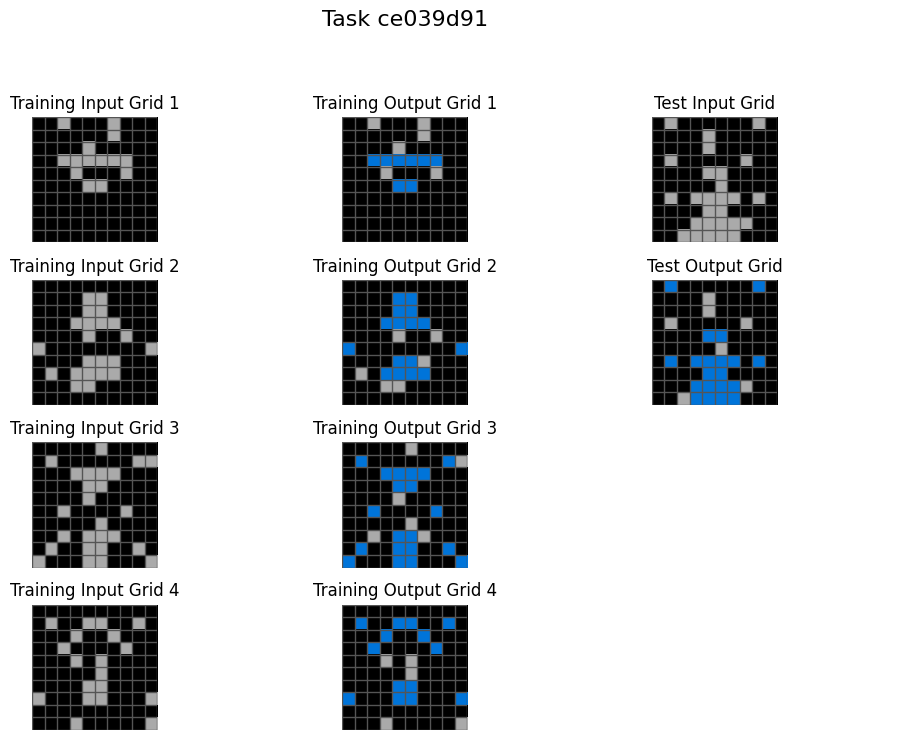

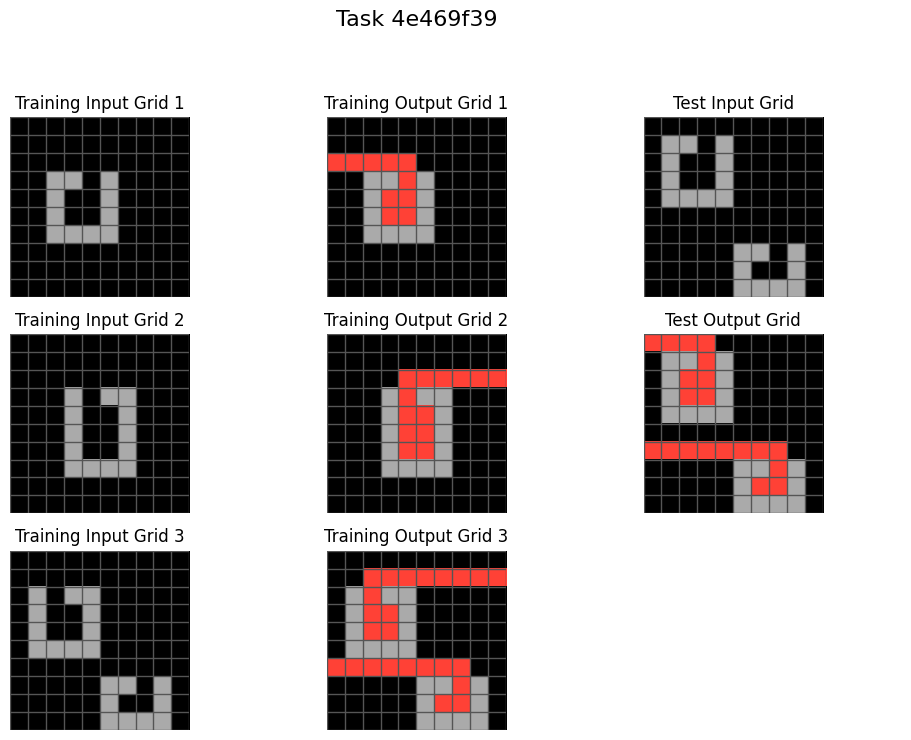

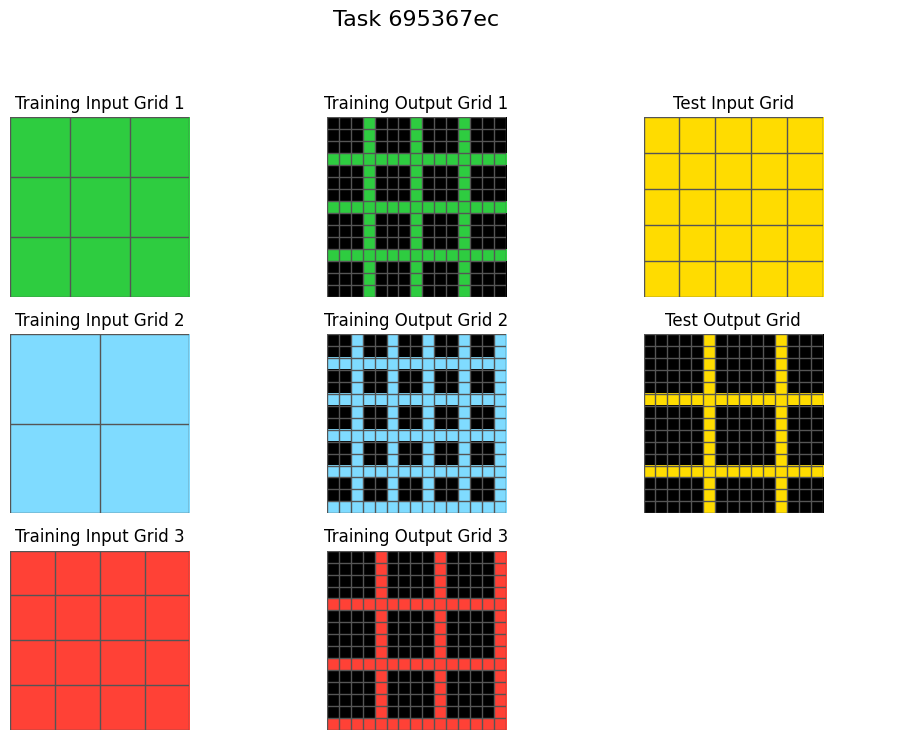

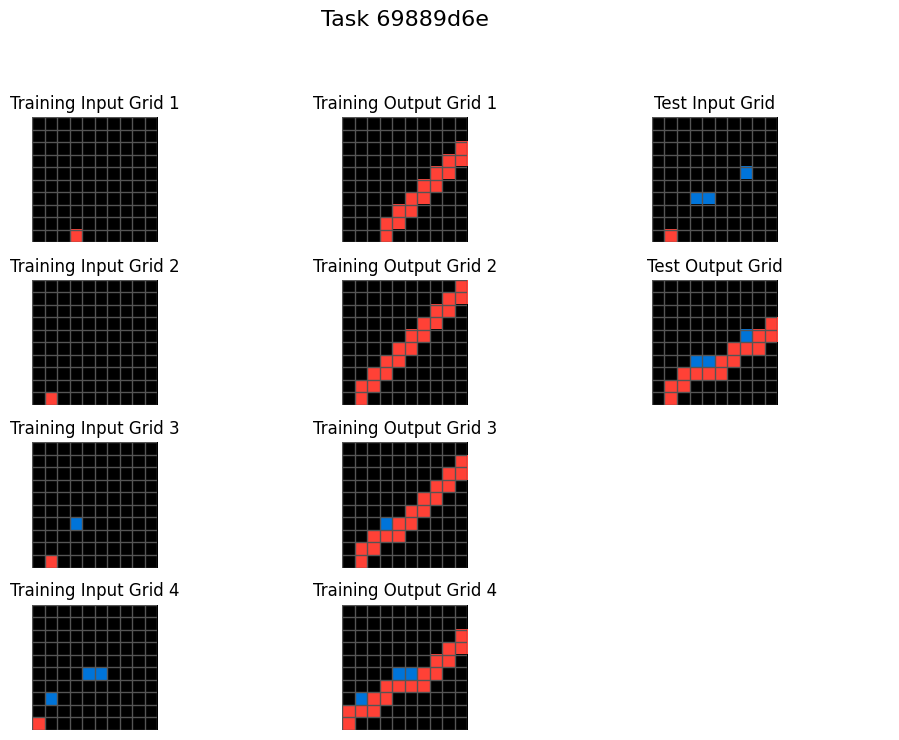

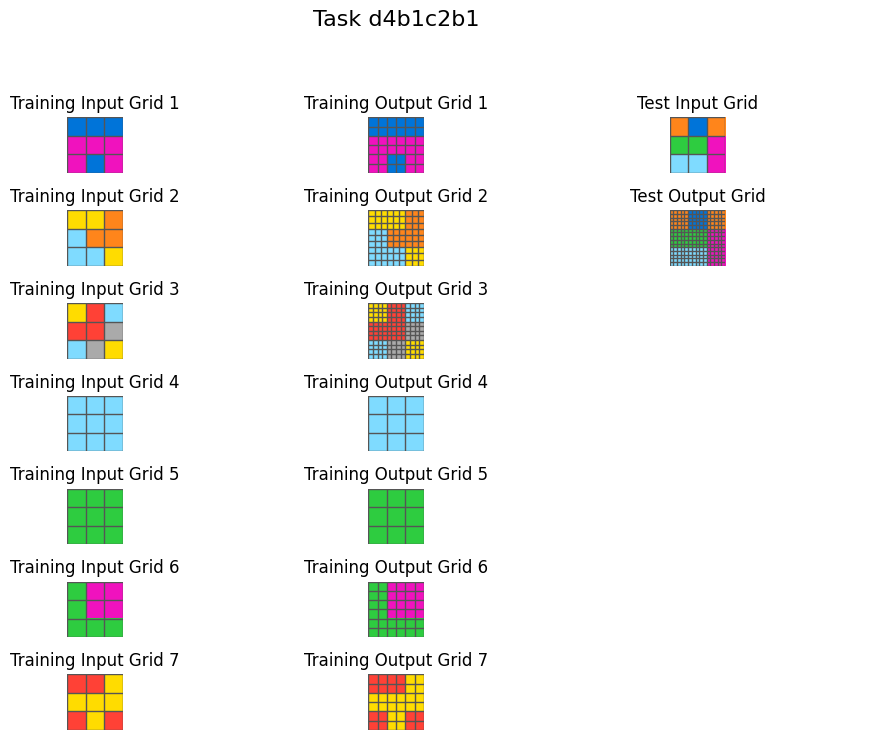

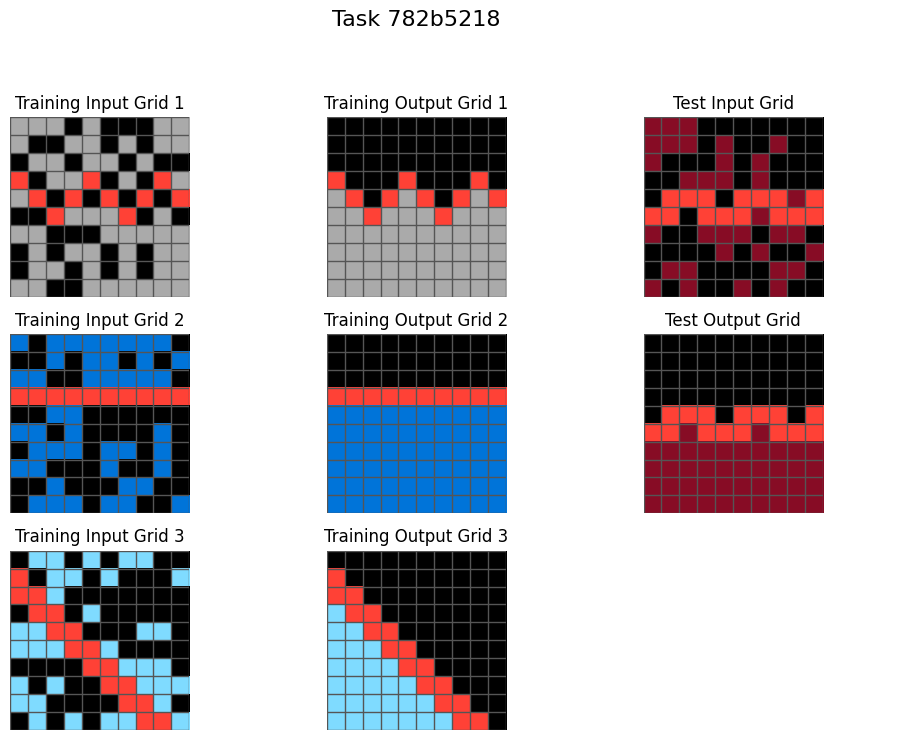

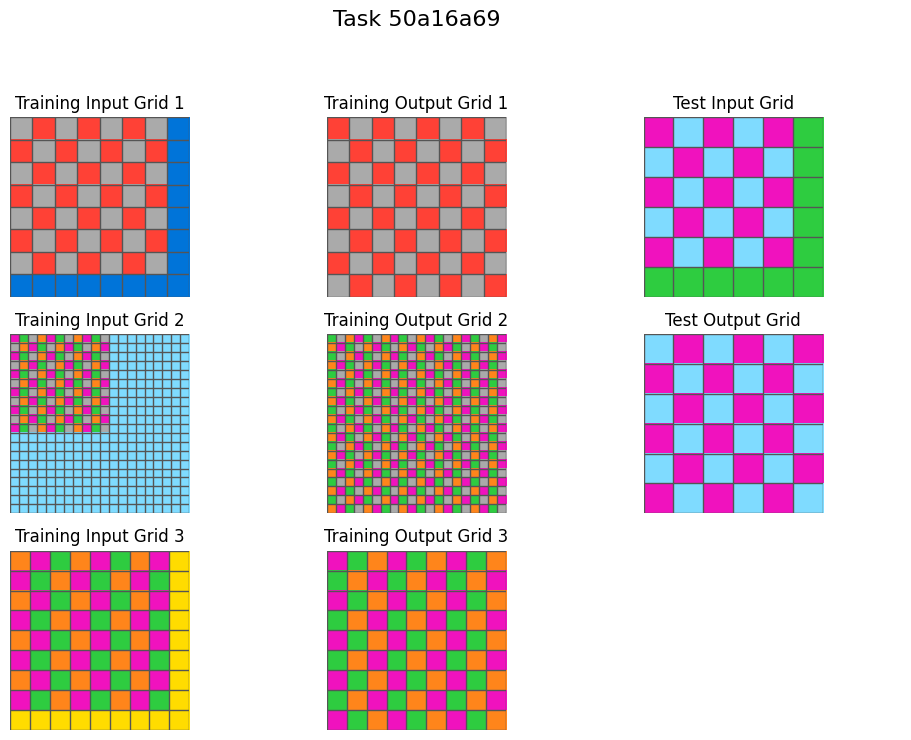

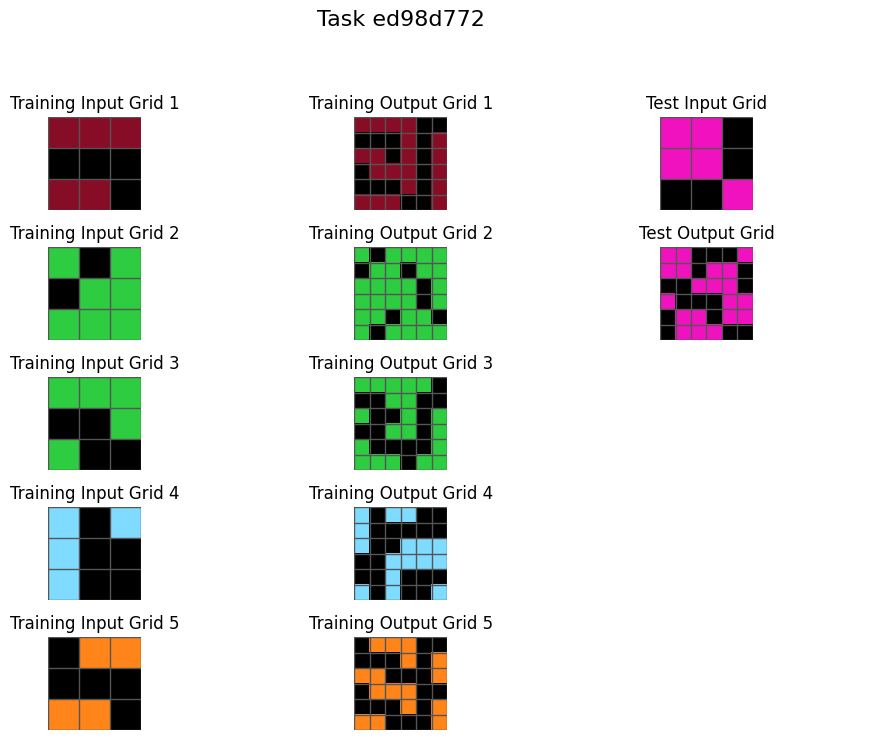

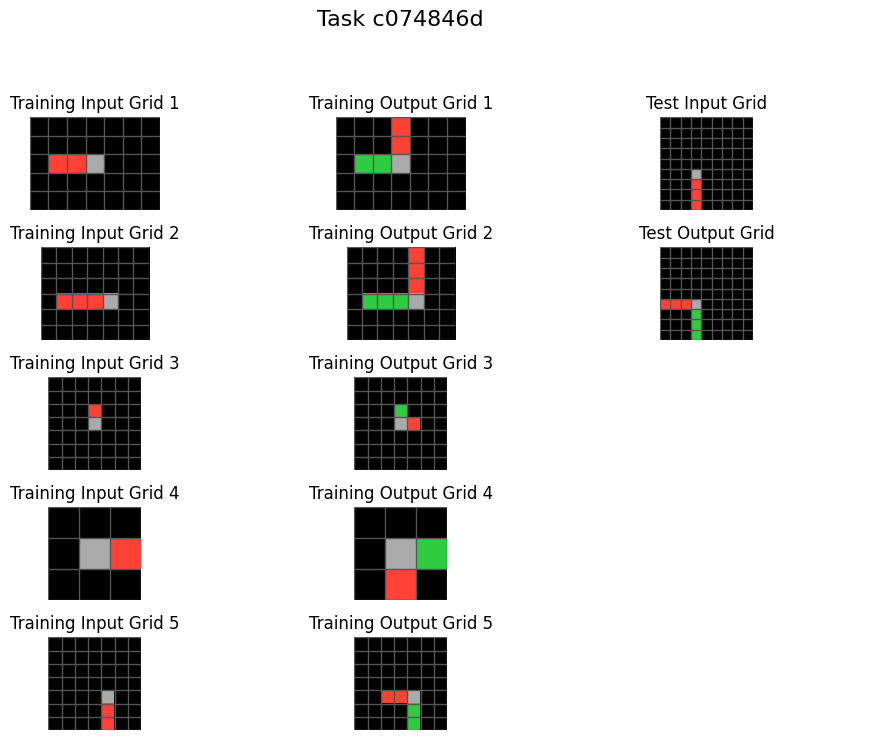

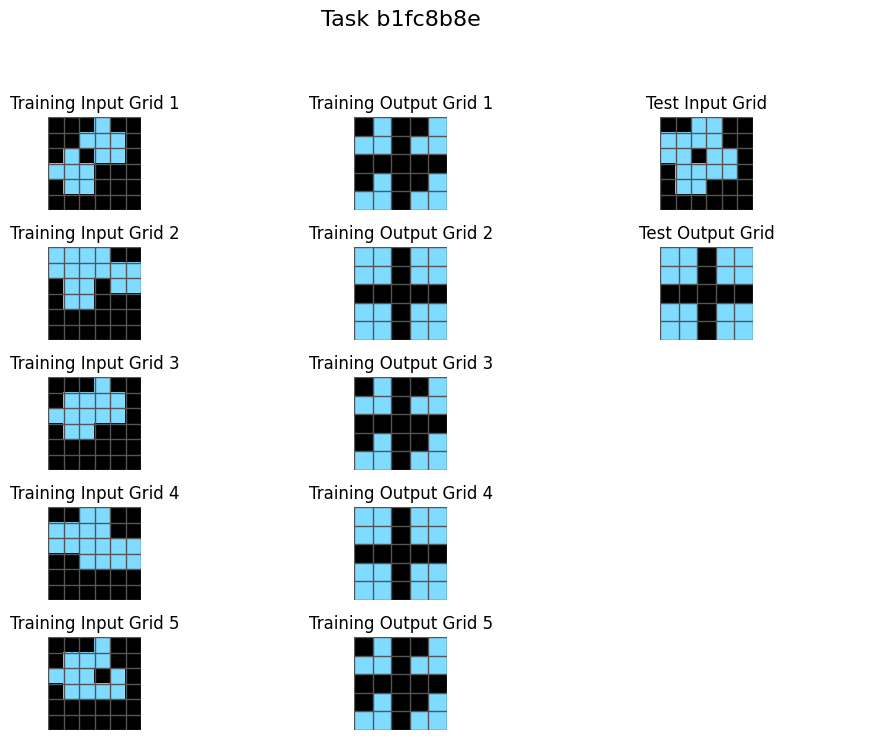

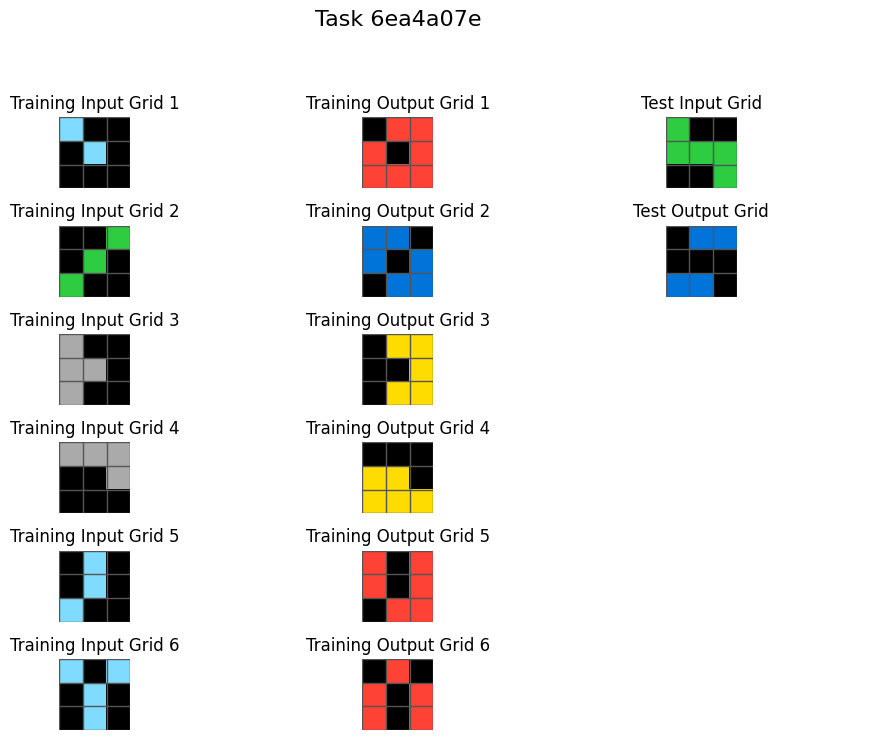

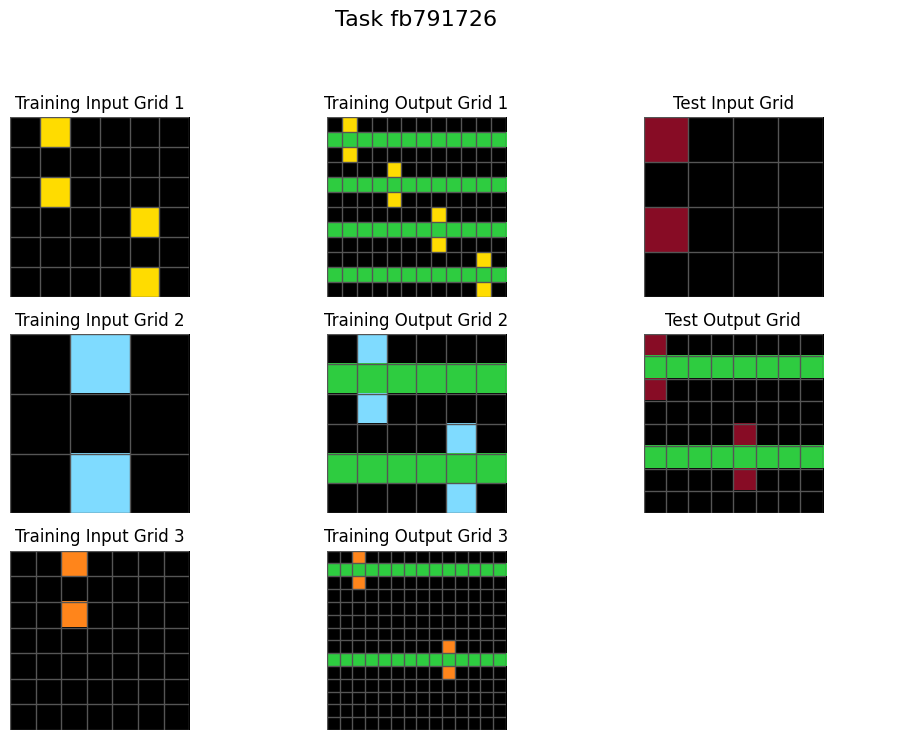

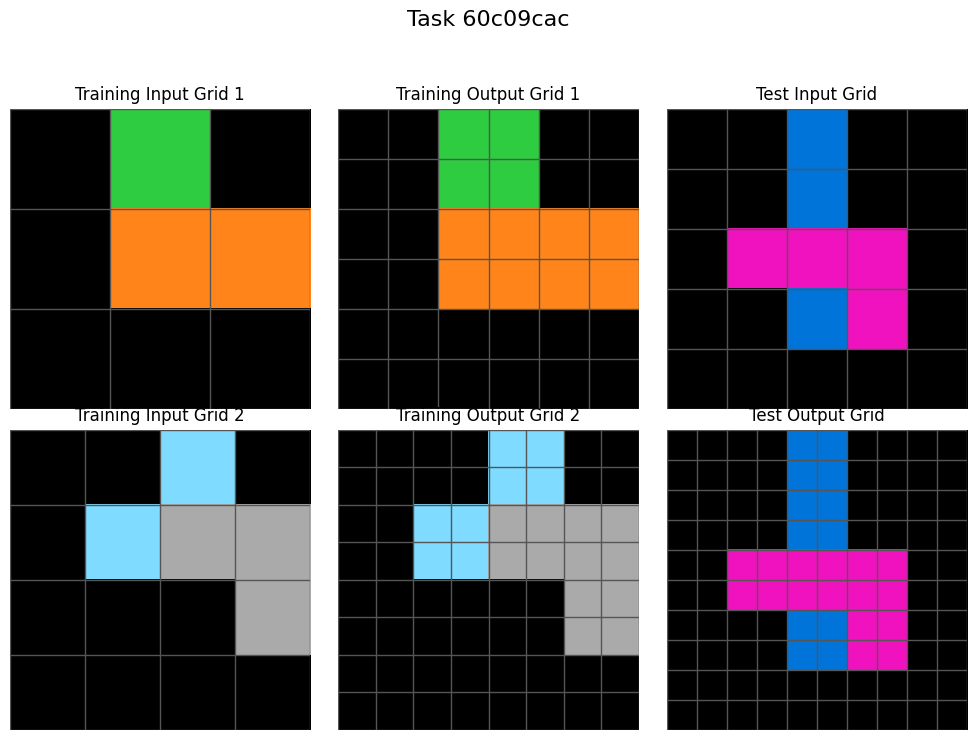

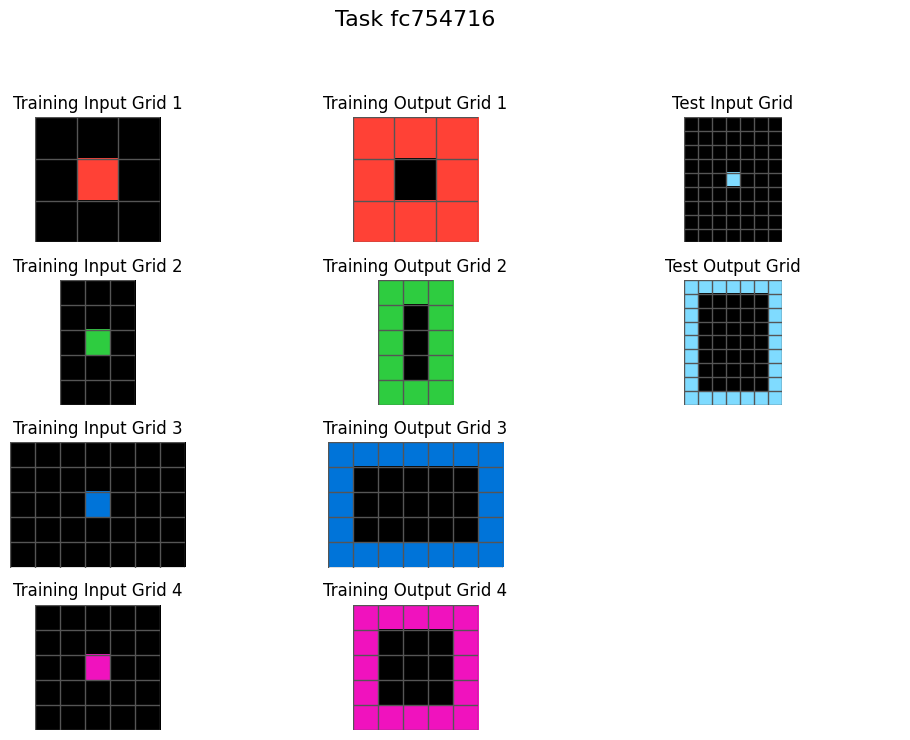

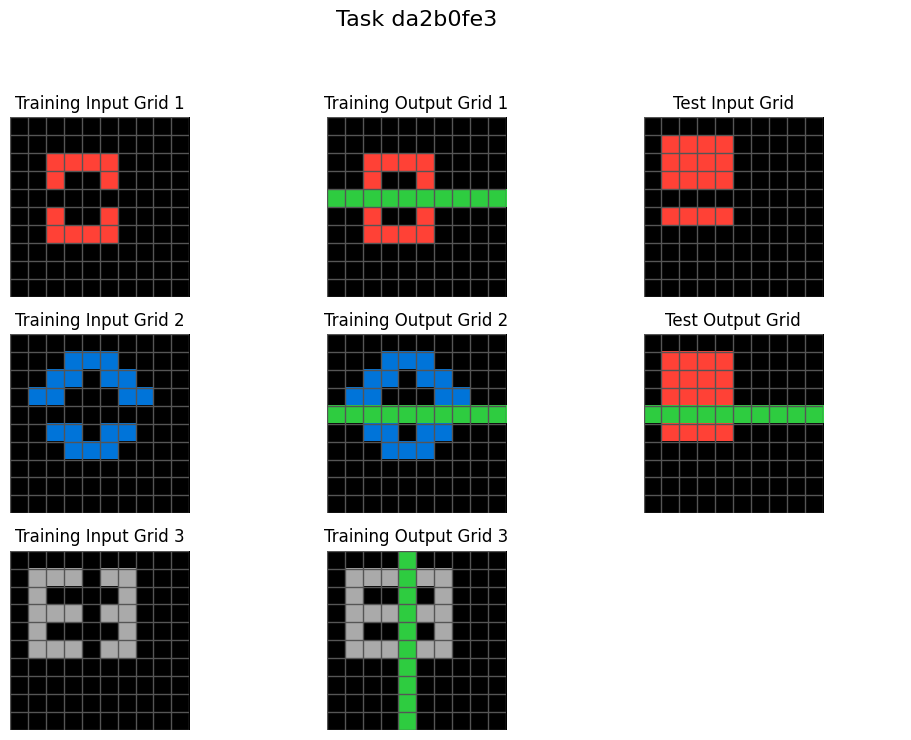

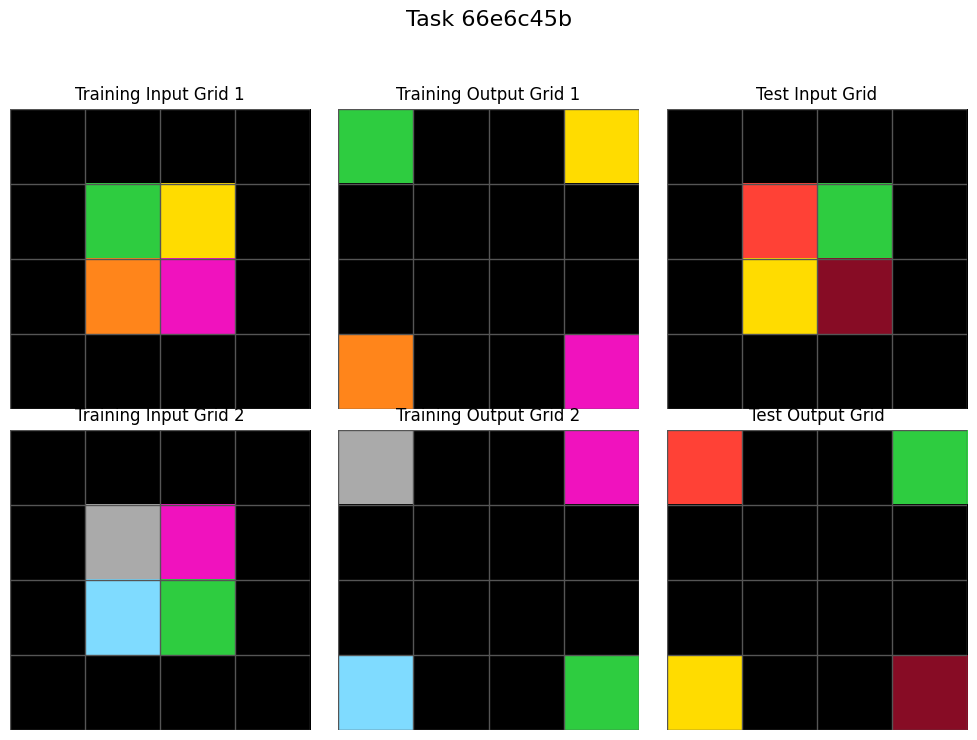

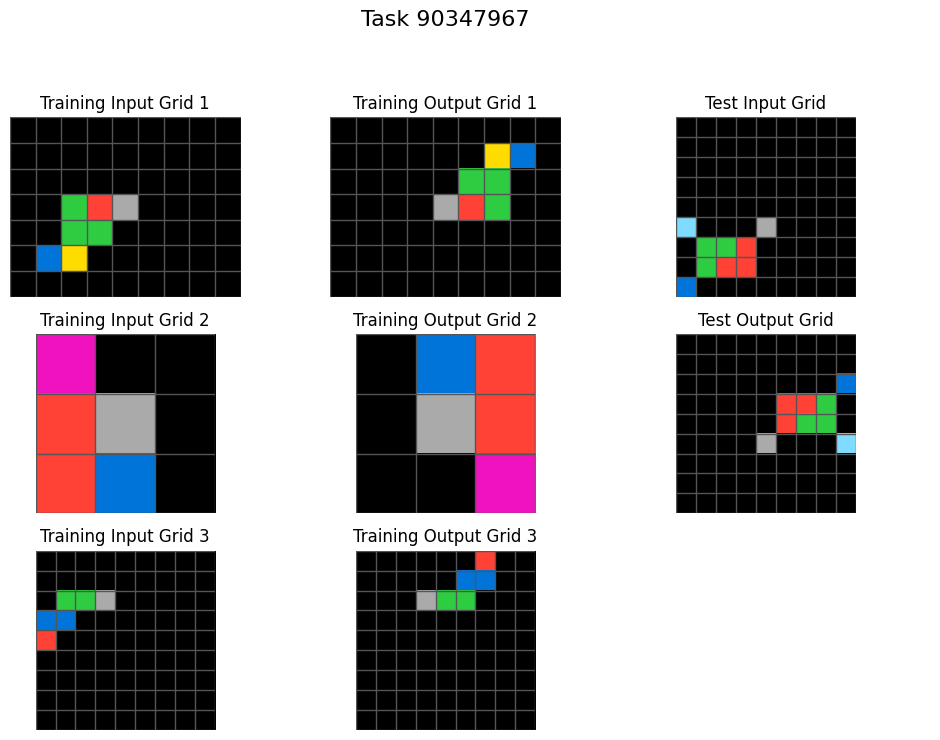

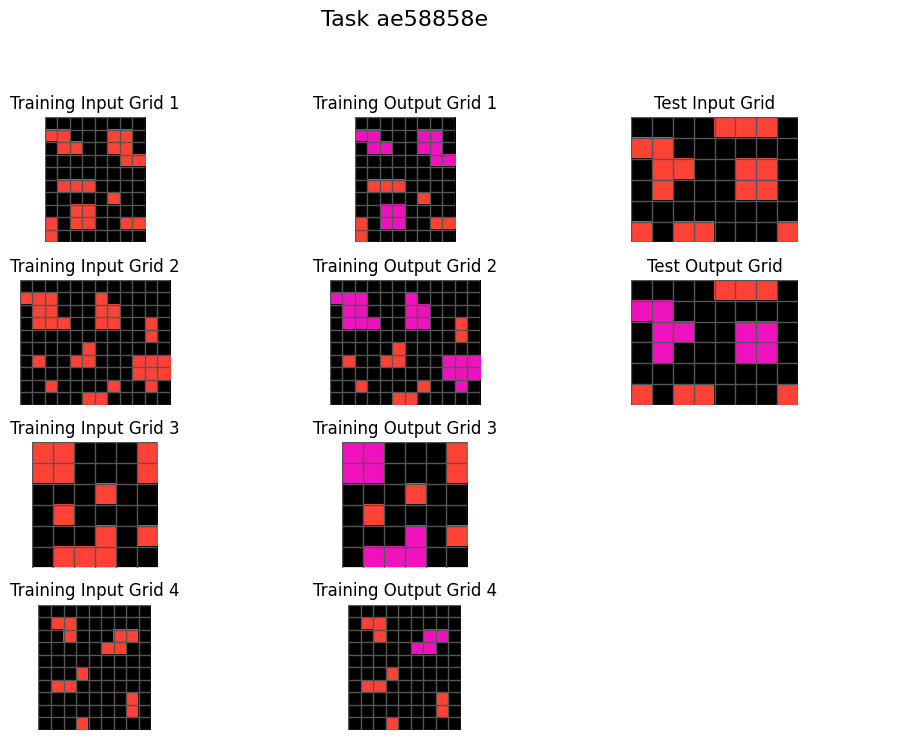

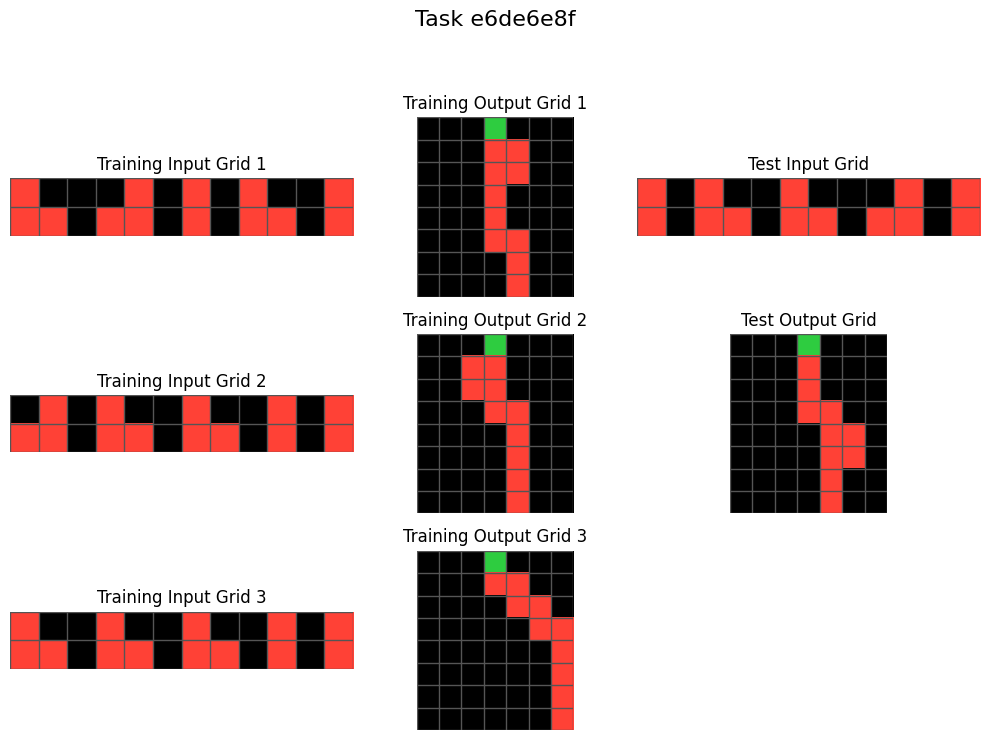

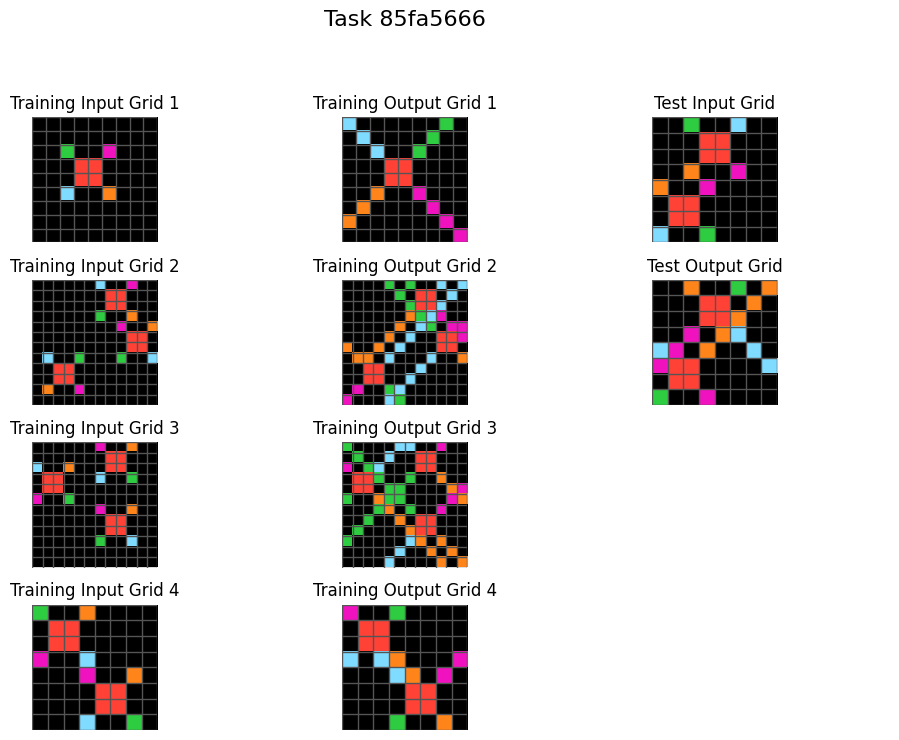

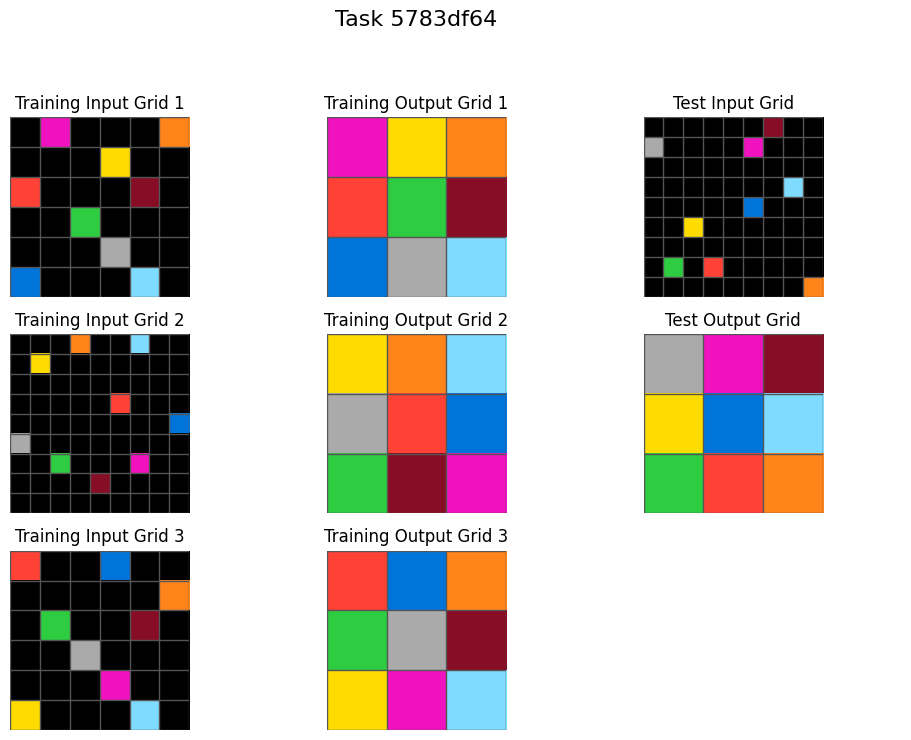

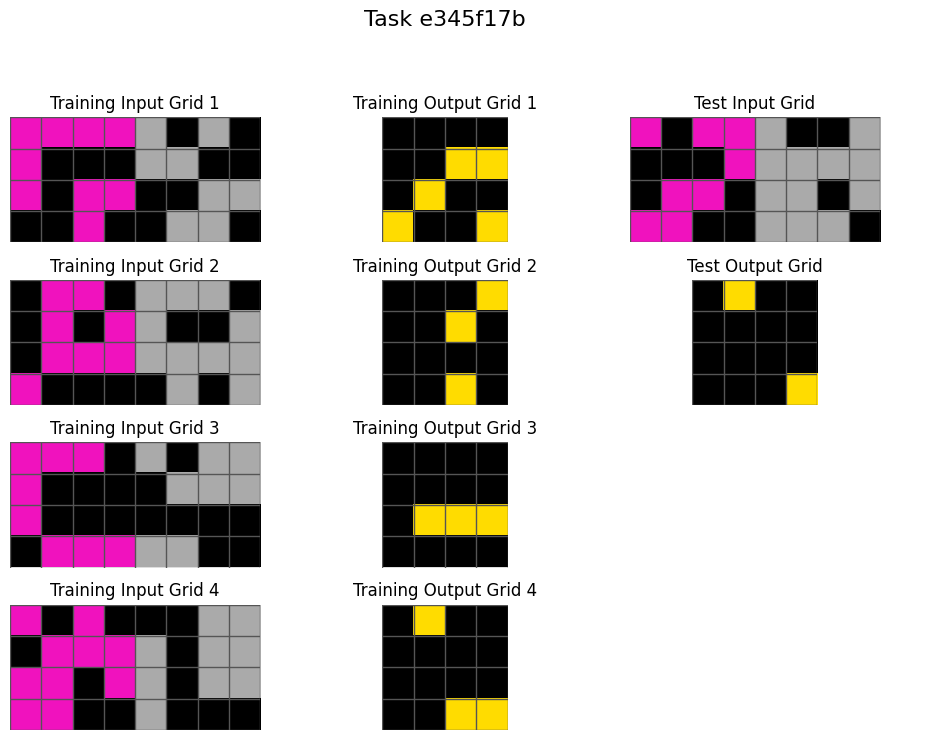

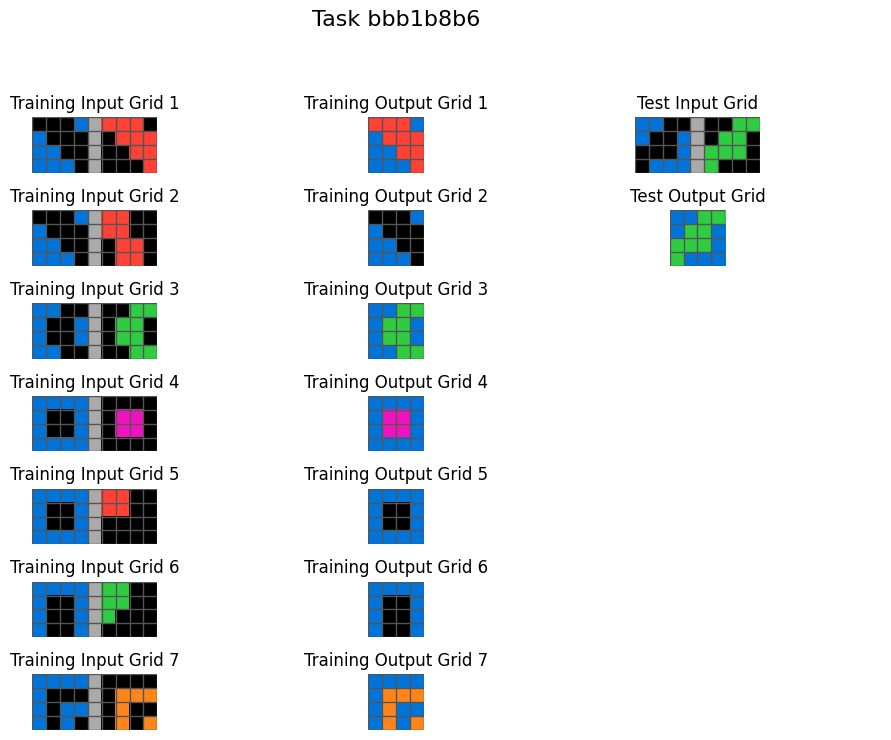

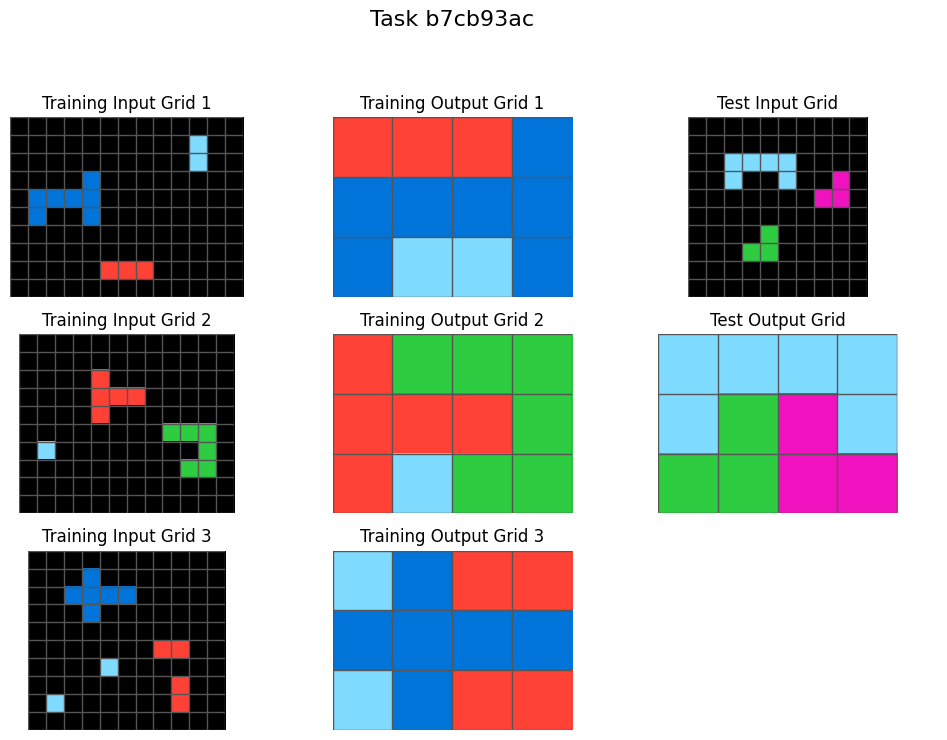

In [14]:
perfect_ids = [k for k, v in train_perf_per_task.items() if v == 1.0]

for puzzle_id in perfect_ids:
    draw_task(data[puzzle_id], task_id=puzzle_id)